# Pilot Data

In [2]:
import pandas as pd
import numpy as np
from embo import InformationBottleneck
import HMM_beads_utils as ut
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
import os,ndd,pickle
from adjustText import adjust_text
cmap = plt.get_cmap("tab10")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
data_location = "./PilotData4/"
stimuli_location = "./Stimuli4/"

file = os.listdir(data_location)[0]
print(file) 

df = pd.read_csv(data_location + file)
print(df)

UrnTaskV_PARTICIPANT_SESSION_2021-06-28_19h11.05.627.csv
                  trial_type  trial_index  time_elapsed internal_node_id  \
0                   pavlovia            0            17          0.0-0.0   
1                    preload            1            18          0.0-1.0   
2              external-html            2         21862      0.0-2.0-0.0   
3        survey-multi-choice            3         25827      0.0-2.0-1.0   
4                survey-text            4         28516      0.0-2.0-2.0   
...                      ...          ...           ...              ...   
3059   image-button-response         3059       1497775   0.0-18.0-2.498   
3060   image-button-response         3060       1498121   0.0-18.0-0.499   
3061   image-button-response         3061       1498423   0.0-18.0-1.499   
3062   image-button-response         3062       1498927   0.0-18.0-2.499   
3063  html-keyboard-response         3063       1527653         0.0-19.0   

      Script_Picker     Block_

In [4]:
os.listdir(data_location)

fl = os.listdir(data_location)[5]

['UrnTaskV_PARTICIPANT_SESSION_2021-06-28_19h11.05.627.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-06-28_12h59.36.18.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-06-28_20h24.29.127.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-06-29_20h23.04.92.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-06-29_18h47.56.645.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-06-28_20h54.32.109.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-06-29_15h39.18.779.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-06-29_17h21.32.648.csv']

In [5]:
df = pd.read_csv(data_location + fl)

In [6]:
df['Script_Picker'].unique()
df.shape

array([21])

(21, 17)

In [7]:
def get_previous_n_beads(w, x):
    '''
    Function that gets history of viewed beads
    Input:
        - w: number of past beads in history
        - x: full sequence of beads
    Output:
        - history: array of strings of previous w beads
    '''
    numtrials = x.shape[0]
    aux_base = 2**np.arange(w)
    x_padded = np.empty(numtrials+w)
    x_padded[:w] = 0
    x_padded[w:] = x
    history_bin = np.array([sum(aux_base * np.array(x_padded[i:(i + w)][::-1])) for i in np.arange(numtrials)])
    return [np.binary_repr(int(z),w+1) for z in history_bin]

In [8]:
def get_windowed_x(x,z,w=1):
    zw = z[w:].copy()
    aux_base = 2**np.arange(w)
    xw_binned = np.array([sum(aux_base*np.array(x[i:(i+w)])) for i in np.arange(len(zw))])
    return(xw_binned,zw)

In [9]:
def get_windowed_x_v(xhist,z,w=1):
    zw = z[w:].copy()
    xw = np.array([int(h[1:][::-1],2) for h in xhist][w:])
    return(xw,zw)

In [10]:
def find_between(s, first, last):
    try:
        start = s.index(first) + len(first)
        end = s.index(last, start)
        return s[start:end]
    except ValueError:
        return ""

In [11]:
def preprocess_sub_data(data_location, stimuli_location, training_length = 10):
    full_data = pd.DataFrame()
    meta_data = pd.DataFrame()
    subject_list = []
    for file in os.listdir(data_location):
        if file[0] == ".": continue
        df = pd.read_csv(data_location + file)
        if df.shape != (3064, 18): continue
        sub_data, meta = preprocess_sub_data_helper(data_location + file, stimuli_location, training_length)
        if sub_data['Subject'][0] not in subject_list:
            subject_list.append(sub_data['Subject'][0])
            full_data = full_data.append(sub_data[10:],ignore_index=True)
            meta_data = meta_data.append(meta,ignore_index=True)
        #print(subject_list)
    return full_data, meta_data
        
def preprocess_sub_data_helper(file_location, stimuli_location, training_length = 10, trial_length = 500, numprevious = 10):
    ## Read in subject data
    df = pd.read_csv(file_location)
    
    ## Read in subject stimulus data
    seqID = df['Script_Picker'].unique()
    print(seqID)
    pseq_lowtrial = pd.read_csv(stimuli_location + 'low_hazard_HMM'+str(seqID[1])+'.csv')
    pseq_low1 = pd.read_csv(stimuli_location + 'low_hazard_HMM'+str(seqID[2])+'.csv')
    pseq_low2 = pd.read_csv(stimuli_location + 'low_hazard_HMM'+str(seqID[3])+'.csv')
    
    ## Subject identifier
    sub = find_between(df['responses'][5],":\"","\"}")
    
    ## Get bead and confidence responses
    temp = df.dropna(subset=['stimulus'])
    resp_combined = temp.loc[temp['stimulus'].str.contains("NewTrial|NoChoice")].reset_index()
    bead_resp = [0 if blah > 1 else 1 for blah in resp_combined['response']]
    confid_resp = [1 if blah % 2 == 0 else 0 for blah in resp_combined['response']]
    
    ## Get true sequence of beads and jars
    pseq = pd.concat([pseq_lowtrial[:training_length],pseq_low1[:trial_length], pseq_low2[:trial_length]])
    pseq = pseq.reset_index()
    
    ## Gather outputs
    D = pd.DataFrame({
        'Subject': sub[:4],
        'Trial': [i for i in np.arange(len(pseq))],
        'Jar': [int(2-i) for i in pseq['Urn']],
        'Bead': [int(2-i) for i in pseq['Bead']],
        'Response': bead_resp,
        'Confidence': confid_resp#,
        #'Combined_response': resp_combined['response']
    })
    D['Correct'] = [1 if D['Response'][i] == D['Bead'][i] else 0 for i in np.arange(len(D))]
    D['History'] = get_previous_n_beads(numprevious, D['Bead'])

    ## Check stuff
    check_set = ['Images/BlackBeadChoiceWrong.png',
                'Images/WhiteBeadChoiceWrong.png',
                'Images/BlackBeadChoiceCorrect.png',
                'Images/WhiteBeadChoiceCorrect.png']
    check_set_string = "|".join(check_set)

    check_table = pd.DataFrame()
    check_table['stim'] = temp['stimulus'].loc[temp['stimulus'].str.contains(check_set_string)]
    check_table['check_resp'] = [0 if "White" in i else 1 for i in check_table['stim']]
    check_table['check_correct'] = [0 if "Wrong" in i else 1 for i in check_table['stim']]
    check_table = check_table.reset_index()
    
    check1 = list(D['Correct']) != list(check_table['check_correct'])
    check2 = list(D['Response']) != list(check_table['check_resp'])
    
    if check1 | check2:
        print("PROBLEM")
        
    M = pd.DataFrame({
    'Subject': [sub[:4]],
    'FullSubject': sub,
    'Gender': find_between(df['responses'][3],":\"","\","),
    'Age': find_between(df['responses'][4],":\"","\"}"),
    'Ethnicity': find_between(df['responses'][3],"1\":\"","\"}")
    })
    M
    return D, M

In [12]:
def gen_sim_pred(sname,beads,jars,trials, p = 0.8,h = 0.01):
    '''
    Function to generate responses from the ideal observer with different internal estimates of p and h
    INPUT:
        - sname: subject identifier in data frame
        - beads: 1D array of observed bead sequence
        - jars: 1D array of jar sequence that generated beads
        - p: internal model estimate of the probability that the bead will match the generating jar
        - h_array: internal estimate of the hazard rate
    OUTPUT:
        -df: data frame with the following columns
            - Subject: subject ID + simulation type (from no noise to lots of noise)
            - Trial: trial number from start of experiment
            - Jar: jar generating the bead
            - Bead: bead observed on each trial
            - Prior: prior probability that the the jar generating the next bead = 1 (before observing the bead)
            - Posterior: posterior probability that the jar generating the last bead = 1 (after observing the bead)
            - Prediction: simulated prediction
    '''
    
    # Initialize
    p_jars = np.array([.5,.5])              # Initial prior
    likes = np.array([[p,(1-p)],[(1-p),p]]) # Likelihood
    prior = np.zeros(len(beads))            # Initialize trial-by-trial priors
    pred_hardmax = np.zeros(len(beads))     # Initialize hardmax predictions
    posterior = np.zeros(len(beads))        # Initialize trial-by-trial posteriors
    
    # Loop through all trials and get simulated responses
    for i in np.arange(len(beads)):
        # Apply hazard rate
        #h = h_array[i]
        z1,z2 = tuple(p_jars.copy())
        p_jars = [(1-h)*z1 + h*z2, (1-h)*z2 + h*z1]

        #Save Prior
        prior[i] = p_jars[1]
        
        # Incorporate likelihood
        p_jars = p_jars*likes[int(beads[i])]
        p_jars = p_jars/sum(p_jars)
        
        # Save posterios
        posterior[i] = p_jars[1]
        
    # Get harmax predictions
    pred_hardmax[prior!=.5] = np.array(prior[prior!=.5] > .5).astype(int)
    pred_hardmax[prior==.5] = np.random.choice([0,1],size=len(prior[prior==.5]),replace=True)
    
    # Save data frame
    df = pd.DataFrame({
        'Subject':np.array([str(sname)+'_Ideal']*len(beads)),
        'Trial':trials,
        'Jar':jars,
        'Bead':beads,
        'Prior':prior,
        'Posterior':posterior,
        'Prediction':pred_hardmax
    })
    return(df)

In [13]:
D1, metaD = preprocess_sub_data(data_location, stimuli_location)

[27 28 29 30]
[21 22 23 24]
[64 65 66 67]
[87 88 89 90]
[44 45 46 47]
[71 72 73 74]


In [14]:
metaD

,Subject,FullSubject,Gender,Age,Ethnicity
0,5ebd,5ebd676b0ee54a0379a10188,Male,20,White
1,5e9d,5e9d28cb23881d258d89cee9,Male,24,Hispanic or Latino
2,5da7,5da7d64e077d260014a456f0,Female,22,White
3,60ce,60ce976010390c070c3d2e1e,Male,30,White
4,5f52,5f52237276d614488e847c1b,Male,41,White
5,60c8,60c86505e26bc5e0e2e725eb,Female,26,White


In [15]:
D1
numprevious = 10
#D[D['Subject'] == D['Subject'].unique()[2]]['Response'].mean()

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History
0,5ebd,10,0,1,0,0,0,00011101101
1,5ebd,11,0,0,1,1,0,00111011011
2,5ebd,12,0,0,0,1,1,01110110110
3,5ebd,13,1,0,0,1,1,01101101100
4,5ebd,14,0,1,0,1,0,01011011000
...,...,...,...,...,...,...,...,...
5995,60c8,1005,0,0,1,1,0,01110111011
5996,60c8,1006,0,0,1,0,0,01101110110
5997,60c8,1007,0,0,0,0,1,01011101100
5998,60c8,1008,0,0,0,0,1,00111011000


In [18]:
D = pd.read_csv('adat_sim.csv')
D.rename(columns=({'Resp': 'Response'}), inplace = True)

halfwidth_ideal = abs(0.5 - D[D['Subject'] == 'Ideal_Hard']['Prior']).mean()
halfwidth_three = abs(0.5 - D[D['Subject'] == 'threeback_A']['Prior']).mean()
for sub in D['Subject'].unique():
    D.loc[D['Subject'] == sub,'History'] = get_previous_n_beads(10, D.loc[D['Subject'] == sub,'Bead'])
    l = len(D.loc[D['Subject'] == sub])
    D.loc[D['Subject'] == sub,'Confidence_Ideal'] = [int(b) for b in abs(0.5 - D.loc[D['Subject'] == 'Ideal_Hard','Prior']) > halfwidth_ideal][-l:]
    temp = [0] * 5 + [int(b) for b in abs(0.5 - D.loc[D['Subject'] == 'threeback_A','Prior']) > halfwidth_three]
    D.loc[D['Subject'] == sub,'Confidence_Three'] = temp[-l:]
    
D.rename(columns=({'Resp': 'Response', 'Confidence_Ideal': 'Confidence'}), inplace = True)
D = D[D['Trial'] > 9]

numprevious = 10

In [19]:
D_ideal2 = pd.read_csv('Ideal2.csv')

D2 = D_ideal2.drop(columns='Unnamed: 0')
halfwidth_ideal2 = abs(0.5 - D2[D2['Subject'] == 'Ideal2_Hard']['Prior']).median()
D2['Confidence'] = [int(b) for b in abs(0.5 - D2['Prior']) > halfwidth_ideal2]
D2['History'] = get_previous_n_beads(10, D2['Bead'])
D2

,Subject,Trial,Jar,Bead,Prior,Posterior,Resp,Confidence,Correct,History,Response
0,Ideal2_Hard,1,1,1,0.500000,0.800000,1.0,0,1,00000000000,1
1,Ideal2_Hard,2,1,1,0.794000,0.939089,1.0,0,1,00000000001,1
2,Ideal2_Hard,3,1,1,0.930308,0.981616,1.0,0,1,00000000011,1
3,Ideal2_Hard,4,1,1,0.971984,0.992846,1.0,0,1,00000000111,1
4,Ideal2_Hard,5,1,1,0.982989,0.995692,1.0,1,1,00000001111,1
...,...,...,...,...,...,...,...,...,...,...,...
995,Ideal2_Hard,996,1,1,0.986711,0.996644,1.0,1,1,01111111111,1
996,Ideal2_Hard,997,1,1,0.986712,0.996644,1.0,1,1,01111111111,1
997,Ideal2_Hard,998,1,1,0.986712,0.996644,1.0,1,1,01111111111,1
998,Ideal2_Hard,999,1,1,0.986712,0.996644,1.0,1,1,01111111111,1


In [980]:
D = pd.concat([D1,D2], join="inner")

In [28]:
D = D1
D

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History
0,5ebd,10,0,1,0,0,0,00011101101
1,5ebd,11,0,0,1,1,0,00111011011
2,5ebd,12,0,0,0,1,1,01110110110
3,5ebd,13,1,0,0,1,1,01101101100
4,5ebd,14,0,1,0,1,0,01011011000
...,...,...,...,...,...,...,...,...
5995,60c8,1005,0,0,1,1,0,01110111011
5996,60c8,1006,0,0,1,0,0,01101110110
5997,60c8,1007,0,0,0,0,1,01011101100
5998,60c8,1008,0,0,0,0,1,00111011000


In [17]:
D['Subject'].unique()

array(['5ebd', '5e9d', '5da7', '60ce', '5f52', '60c8'], dtype=object)

In [18]:
D_ideal

NameError: name 'D_ideal' is not defined

In [19]:
for sub in D['Subject'].unique():
    if sub.find("Ideal") == -1:
        D_sub = D[D['Subject'] == sub].reset_index(drop = True)
        #prop_high = D_sub['Confidence'].mean()
        num_high = D_sub['Confidence'].sum()
        #num_high
        D_ideal_full = gen_sim_pred(sub, D_sub['Bead'], D_sub['Jar'], D_sub['Trial'])
        #thresh = np.percentile(abs(0.5 - D_ideal_full['Prior']), 100*(1-prop_high)/2)

        D_ideal = D_sub.copy()
        D_ideal['Subject'] = [sub+'_Ideal']*len(D_sub)
        D_ideal_full['Abs_Prior'] = abs(0.5 - D_ideal_full['Prior'])
        trials_ideal_high = D_ideal_full.sort_values('Abs_Prior',ascending = False)['Trial'].head(num_high).values
        D_ideal['Confidence'] = [int(t in trials_ideal_high) for t in D_ideal['Trial']]
        #D_ideal['Confidence'] = [int(b) for b in abs(0.5 - D_ideal_full['Prior']) > thresh]
        #D_ideal = D_ideal.merge(D_sub[D_sub.columns.difference(D_ideal.columns)], how = "outer", left_index = True, right_index = True)

        D_random = D_sub.copy()
        D_random['Subject'] = [sub+'_Random']*len(D_sub)
        trials_random_high = D_random.sample(n=num_high)['Trial'].values
        D_random['Confidence'] = [int(t in trials_random_high) for t in D_ideal['Trial']]

        D = D.append(D_ideal)
        D = D.append(D_random)


In [20]:
D

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History
0,5ebd,10,0,1,0,0,0,00011101101
1,5ebd,11,0,0,1,1,0,00111011011
2,5ebd,12,0,0,0,1,1,01110110110
3,5ebd,13,1,0,0,1,1,01101101100
4,5ebd,14,0,1,0,1,0,01011011000
...,...,...,...,...,...,...,...,...
995,60c8_Random,1005,0,0,1,0,0,01110111011
996,60c8_Random,1006,0,0,1,1,0,01101110110
997,60c8_Random,1007,0,0,0,0,1,01011101100
998,60c8_Random,1008,0,0,0,1,1,00111011000


In [21]:
D
D.groupby(['Subject']).head()

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History
0,5ebd,10,0,1,0,0,0,00011101101
1,5ebd,11,0,0,1,1,0,00111011011
2,5ebd,12,0,0,0,1,1,01110110110
3,5ebd,13,1,0,0,1,1,01101101100
4,5ebd,14,0,1,0,1,0,01011011000
...,...,...,...,...,...,...,...,...
995,60c8_Random,1005,0,0,1,0,0,01110111011
996,60c8_Random,1006,0,0,1,1,0,01101110110
997,60c8_Random,1007,0,0,0,0,1,01011101100
998,60c8_Random,1008,0,0,0,1,1,00111011000


,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History
0,5ebd,10,0,1,0,0,0,00011101101
1,5ebd,11,0,0,1,1,0,00111011011
2,5ebd,12,0,0,0,1,1,01110110110
3,5ebd,13,1,0,0,1,1,01101101100
4,5ebd,14,0,1,0,1,0,01011011000
...,...,...,...,...,...,...,...,...
0,60c8_Random,10,0,1,1,1,1,01110000000
1,60c8_Random,11,0,0,1,1,0,01100000001
2,60c8_Random,12,0,0,0,0,1,01000000010
3,60c8_Random,13,0,0,0,0,1,00000000100


In [22]:
acc = D[['Subject','Correct']].groupby(['Subject'],as_index=False).mean()
conf = D[['Subject','Confidence']].groupby(['Subject'],as_index=False).mean()

metaDw = pd.merge(metaD, pd.merge(acc, conf))
metaDw

#metaDw.to_csv("../UrnConfidenceQuestionnaire/Data/subjectmeta.csv", index=False)

,Subject,FullSubject,Gender,Age,Ethnicity,Correct,Confidence
0,5ebd,5ebd676b0ee54a0379a10188,Male,20,White,0.626,0.998
1,5e9d,5e9d28cb23881d258d89cee9,Male,24,Hispanic or Latino,0.604,0.557
2,5da7,5da7d64e077d260014a456f0,Female,22,White,0.664,0.709
3,60ce,60ce976010390c070c3d2e1e,Male,30,White,0.658,0.473
4,5f52,5f52237276d614488e847c1b,Male,41,White,0.653,0.728
5,60c8,60c86505e26bc5e0e2e725eb,Female,26,White,0.644,0.465


<Figure size 1080x432 with 0 Axes>

<AxesSubplot:>

Text(20, 0, '0.664')

Text(20, 0, '0.604')

Text(20, 0, '0.626')

Text(20, 0, '0.653')

Text(20, 0, '0.644')

Text(20, 0, '0.658')

Text(0.5, 0, 'Accuracy')

Text(0, 0.5, 'Subject')

(-0.05, 1.05)

<AxesSubplot:>

Text(20, 0, '0.709')

Text(20, 0, '0.557')

Text(20, 0, '0.998')

Text(20, 0, '0.728')

Text(20, 0, '0.465')

Text(20, 0, '0.473')

Text(0.5, 0, 'Proportion High Confidence')

Text(0, 0.5, 'Subject')

(-0.05, 1.05)

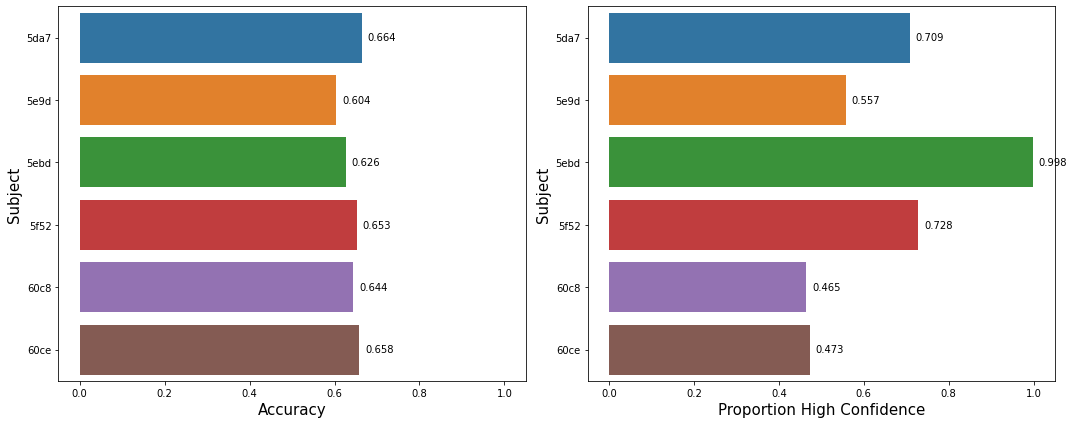

In [29]:
plt.figure(1,(15,6))

## Plot accuracy bar overall
plt.subplot(1,2,1)
splot = sns.barplot(y="Subject", x="Correct", 
            data=D[['Subject','Correct']].groupby(['Subject'],as_index=False).mean())
#plt.ylim([0,1])
for p in splot.patches:
    splot.annotate(format(p.get_width(), '.3f'), 
                   (p.get_width(), p.get_y() + p.get_height() / 2.), 
                   ha = 'center', va = 'center', 
                   xytext = (20, 0), 
                   textcoords = 'offset points')
plt.xlabel('Accuracy',size=15)
plt.ylabel('Subject',size=15)
plt.xlim([-.05,1.05])
plt.tight_layout()

## Plot confidence bar overall
plt.subplot(1,2,2)
splot = sns.barplot(y="Subject", x="Confidence", 
            data=D[['Subject','Confidence']].groupby(['Subject'],as_index=False).mean())
#plt.axvline(x=1, ls = '--')
#plt.ylim([0,1])
for p in splot.patches:
    splot.annotate(format(p.get_width(), '.3f'), 
                   (p.get_width(), p.get_y() + p.get_height() / 2.), 
                   ha = 'center', va = 'center', 
                   xytext = (20, 0), 
                   textcoords = 'offset points')
plt.xlabel('Proportion High Confidence',size=15)
plt.ylabel('Subject',size=15)
plt.xlim([-.05,1.05])
plt.tight_layout()

#plt.savefig('AccuracyConfidenceBar.png')

In [45]:
D[['Subject','Correct']].groupby(['Subject'],as_index=False).mean()['Correct'].mean()
D[['Subject','Correct']].groupby(['Subject'],as_index=False).mean()['Correct'].var()
D[['Subject','Correct']].groupby(['Subject'],as_index=False).mean()['Correct'].std()

0.6415000000000001

0.0005127000000000009

0.022642879675518326

In [48]:
0.6415000000000001 - 3 * 0.022642879675518326

0.5735713609734451

In [30]:
numprevious
D['Subject'].unique()
#D['H'].unique()

10

array(['5ebd', '5e9d', '5da7', '60ce', '5f52', '60c8'], dtype=object)

<Figure size 576x432 with 0 Axes>

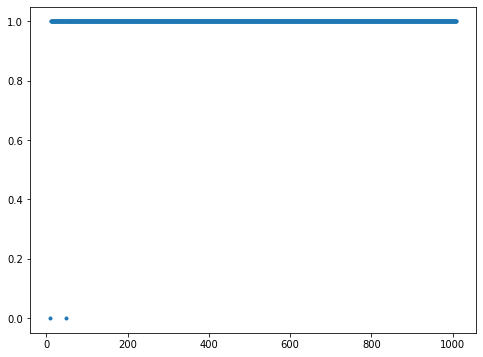

In [31]:
plt.figure(1,(8,6))
plt.plot("Trial", "Confidence",'.',data = D[D['Subject'] == D['Subject'].unique()[0]])

<Figure size 1080x432 with 0 Axes>

<AxesSubplot:>

(0.0, 1.0)

Text(20, 0, '0.550')

Text(20, 0, '0.560')

Text(20, 0, '0.000')

Text(20, 0, '0.585')

Text(20, 0, '0.585')

Text(20, 0, '0.626')

Text(20, 0, '0.711')

Text(20, 0, '0.639')

Text(20, 0, '0.627')

Text(20, 0, '0.679')

Text(20, 0, '0.712')

Text(20, 0, '0.693')

Text(0.5, 0, 'Accuracy')

Text(0, 0.5, 'Subject')

<AxesSubplot:>

(0.0, 1.0)

Text(20, 0, '0.610')

Text(20, 0, '0.508')

Text(20, 0, '0.995')

Text(20, 0, '0.674')

Text(20, 0, '0.376')

Text(20, 0, '0.424')

Text(20, 0, '0.759')

Text(20, 0, '0.589')

Text(20, 0, '1.000')

Text(20, 0, '0.757')

Text(20, 0, '0.514')

Text(20, 0, '0.498')

Text(0.5, 0, 'Proportion High Confidence')

Text(0, 0.5, 'Subject')

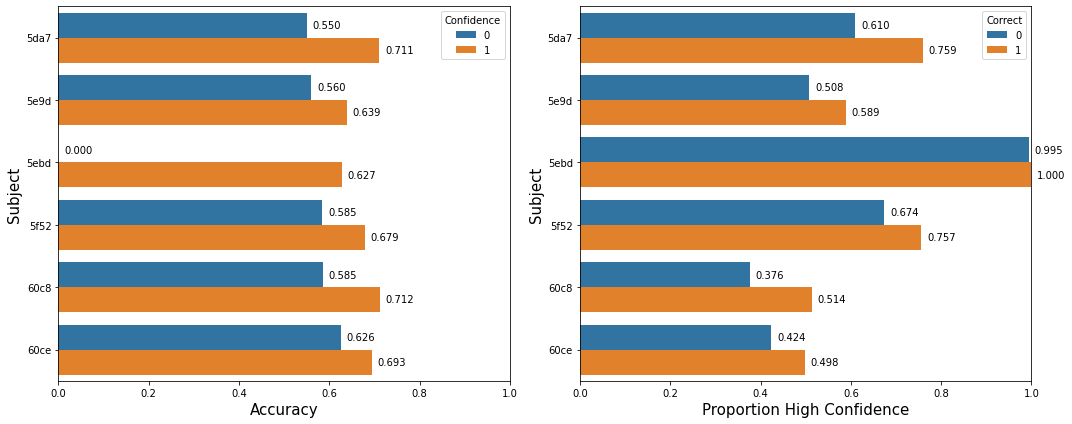

In [32]:
## Relationships between accuracy and confidence
plt.figure(1,(15,6))
# Accuracy split by confidence
plt.subplot(1,2,1)
splot = sns.barplot(y="Subject", x="Correct", hue="Confidence", 
            data=D[['Subject','Correct','Confidence']].groupby(['Subject','Confidence'],as_index=False).mean())
plt.xlim([0,1])
for p in splot.patches:
    splot.annotate(format(p.get_width(), '.3f'), 
                   (p.get_width(), p.get_y() + p.get_height() / 2.), 
                   ha = 'center', va = 'center', 
                   xytext = (20, 0), 
                   textcoords = 'offset points')
plt.xlabel('Accuracy',size=15)
plt.ylabel('Subject',size=15)
plt.tight_layout()

# Confidence split by correctness
plt.subplot(1,2,2)
splot = sns.barplot(y="Subject", x="Confidence", hue="Correct", 
            data=D[['Subject','Correct','Confidence']].groupby(['Subject','Correct'],as_index=False).mean())
plt.xlim([0,1])
for p in splot.patches:
    splot.annotate(format(p.get_width(), '.3f'), 
                   (p.get_width(), p.get_y() + p.get_height() / 2.), 
                   ha = 'center', va = 'center', 
                   xytext = (20, 0), 
                   textcoords = 'offset points')
plt.xlabel('Proportion High Confidence',size=15)
plt.ylabel('Subject',size=15)
plt.tight_layout()

#plt.savefig('AccuracyConfidenceSplitBar.png')

In [33]:
D['Subject'].unique()[3]

'60ce'

In [34]:
nw = numprevious
adat_trials = D[D['Subject'] == D['Subject'].unique()[3]].copy()
adat_trials['History'] = get_previous_n_beads(nw, adat_trials['Bead'])


In [35]:
adat_trials
#adat_mis_h1 


,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History
3000,60ce,10,1,1,0,0,0,00000000000
3001,60ce,11,0,0,1,0,0,00000000001
3002,60ce,12,0,0,0,0,1,00000000010
3003,60ce,13,0,0,0,1,1,00000000100
3004,60ce,14,0,0,0,0,1,00000001000
...,...,...,...,...,...,...,...,...
3995,60ce,1005,1,1,0,0,0,00000000001
3996,60ce,1006,1,0,1,0,0,00000000011
3997,60ce,1007,1,1,1,0,1,00000000110
3998,60ce,1008,1,1,1,1,1,00000001101


<Figure size 576x432 with 0 Axes>

Text(0, 0.5, 'Mutual Information between\n$X_{past}$ and $X_{future}$')

Text(0.5, 0, 'Window size of $X$ into the past')

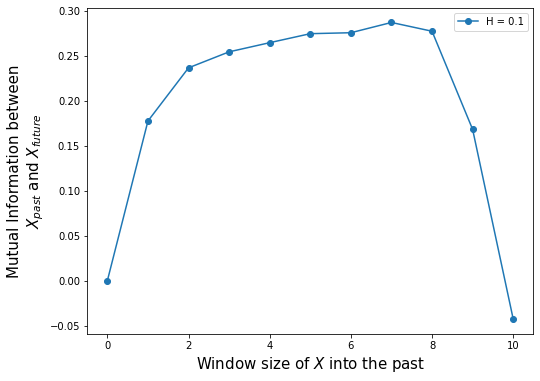

In [36]:
# Test bounds in each session
def get_windowed_mi(x_array,z,nw,confid = 0):
    '''
    Function that windows of observations from a sequence x offset from y and computes the MI
    Input:
        - x: sequence of "past" observations to be windowed
        - z: sequence that serves as the "future" events
        - nw: maximum window size
    Output:
        - mis: NSB estimated mutual informtion values for each window size
    '''
    mis = np.zeros(nw+1) #vector of mutual informations for different window sizes
    for w in np.arange(1,nw+1):
        xw,zw = get_windowed_x_v(['0' + h[-w:] for h in x_array],z,w=w)         # use convenience function from utilities to window x
        mis[w] = ut.mutual_inf_nsb(xw,zw,[2**w,2+confid*2]) # use convenience function from utilities to compute NSB mutual info
    return(mis)

# Get all trials in all three sessions that match low and high hazard rates
nw = numprevious #number of windows into the past we want to compute

#Since everyone saw the same sequence, we can speed this up by subselecting one example of all the trials the first subject saw
adat_trials = D[D['Subject'] == D['Subject'].unique()[3]].copy()
adat_trials['History'] = get_previous_n_beads(nw, adat_trials['Bead'])

# Computed windowed predictive information in the low hazard rate
adat_mis_h1 = get_windowed_mi(adat_trials['History'],
                              adat_trials['Jar'],nw)

# Plot predictive information as a function of window size
plt.figure(1,(8,6))
plt.plot(np.arange(nw+1),adat_mis_h1,'-o',label='H = 0.1')
#plt.plot(np.arange(nw+1),adat_mis_h9,'-o', label = "H = 0.99")
plt.ylabel('Mutual Information between\n$X_{past}$ and $X_{future}$',size=15)
plt.xlabel('Window size of $X$ into the past',size=15)
plt.legend()

#adat_trials.to_csv("adat_trials_test.csv")

[ 1  0  0  0  0  0 32 48 56 60 30 47 55 59 29 46 55 59 61 62 63 63 63 63
 63 31 47 55 59 61 62 63 31 47 55 27 13 38 19  9  4  2  1  0 32 16  8 36
 18  9  4  2  1  0  0 32 16 40 20 42 53 58 61 62 63 63 31 15  7 35 49 56
 60 30 47 23 43 53 58 61 30 15  7  3  1  0  0  0  0  0  0  0 32 48 56 60
 62 63 63 63 63 63 63 63 63 63 63 63 63 31 15 39 19 41 20 10  5  2  1 32
 16 40 52 58 29 14 39 51 25 44 22 43 21 42 21 10 37 18 41 20 10 37 18  9
 36 18 41 52 58 61 62 63 63 63 63 63 63 63 63 63 31 47 55 59 61 30 47 55
 59 61 62 63 63 63 31 47 23 11  5  2  1 32 48 24 12  6 35 17  8  4 34 49
 24 44 22 11  5  2 33 48 56 60 62 63 63 31 47 55 27 45 22 11  5  2  1 32
 48 56 60 62 31 15  7  3  1  0  0  0  0 32 48 56 60 62 31 47 55 59 61 62
 31 47 55 59 61 62 63 31 15  7  3 33 16  8  4  2  1 32 48 24 44 54 59 29
 14 39 51 25 44 22 43 21 42 53 58 29 46 55 59 29 46 23 43 53 58 61 30 47
 23 43 21 42 53 58 29 46 55 27 45 22 11  5 34 17  8  4  2  1 32 48 56 60
 30 47 55 59 29 46 55 59 61 62 63 63 63 63 63 63 63

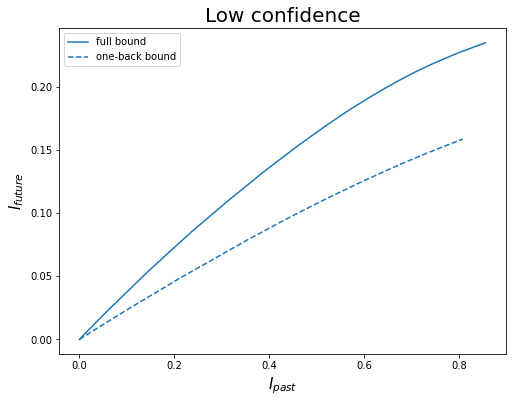

In [37]:
%%time
def get_windowed_bound(x_array,z,w,mb=50,nb=2000,p=8):
    '''
    Function that computes the information bottleneck bound between two discrete variables
    Input:
        - x: sequence of past events
        - z: sequence of future events
        - w: size of the window to be applied to x
        - mb: maximum value of the lagrange multiplier beta
        - nb: number of values of beta between 0 and mb to be run through the Blahaut-Arimoto algorithm
        - p: number of cores to use in the computation (to help with speed)
    Output:
        - 4 element tuple with a sequence of ipast and ifuture values corresponding to the information bottleneck for full and one back bounds
    '''
    # Get desired windowed x and corresponding z
    xw,zw = get_windowed_x_v(['0' + h[-w:] for h in x_array],z,w=w)
    print(xw)
    print(zw)
    # Compute the information bottleneck using EMBO for the window size w specified above
    ipw, ifw, _, _= InformationBottleneck(xw, zw, window_size_x=1, window_size_y=1).get_bottleneck()

    # Compute the information bottleneck using EMBO for the window size w specified above
    x1b,z1b = get_windowed_x_v(['0' + h[-1:] for h in x_array],z,w=1)
    ip1b, if1b, _, _ = InformationBottleneck(x1b, z1b, window_size_x=1, window_size_y=1).get_bottleneck()   
    
    # Return informtion bottleneck
    return((ipw,ifw,ip1b,if1b))

# For speed, see if bottleneck has already been computed
#try:
    # Low hazard full and 1-back bounds
#    ipw_h1,ifw_h1,ipw_h1_1back,ifw_h1_1back = pickle.load(open('ipw_h1_bounds.pkl','rb'))
    
    # High hazard full and 1-back bounds
#    ipw_h9,ifw_h9, ipw_h9_1back,ifw_h9_1back = pickle.load(open('ipw_h9_bounds.pkl','rb'))
    
#except:
    # If no objects exist, compute full and one-back bounds for each confidence rate
    #Low confidence full and 1-back bounds
ipw_h1,ifw_h1,ipw_h1_1back,ifw_h1_1back = get_windowed_bound(adat_trials['History'],
                                                             adat_trials['Jar'],6)
#pickle.dump((ipw_h1,ifw_h1,ipw_h1_1back,ifw_h1_1back),open('ipw_h1_bounds.pkl','wb')) 

    
# Plot bounds
plt.figure(1,(8,6))

# Low confidence rate
#plt.subplot(1,2,1)
plt.plot(ipw_h1,ifw_h1,'-',color=cmap(0),label='full bound')
plt.plot(ipw_h1_1back,ifw_h1_1back,'--',color=cmap(0), label='one-back bound')
#plt.ylim([0,.8])
plt.xlabel('$I_{past}$',size=15)
plt.ylabel('$I_{future}$',size=15)
plt.title('Low confidence',size=20)
plt.legend()

CPU times: user 604 ms, sys: 7.57 ms, total: 612 ms
Wall time: 611 ms


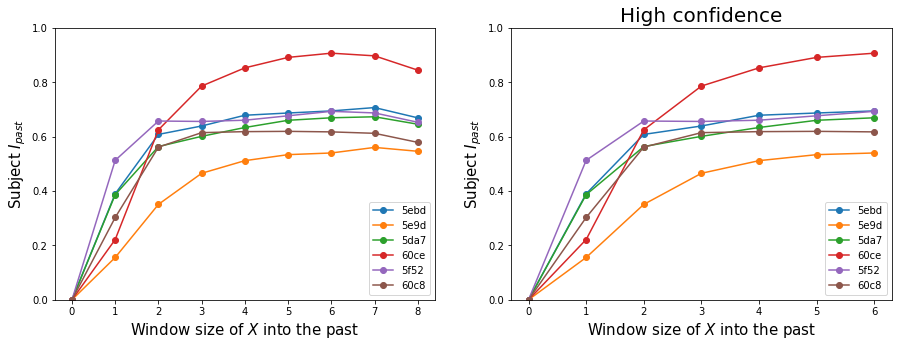

In [40]:
%%time
def get_windowed_mi_subs(sdat_all,nw):
    '''
    Function to compute windowed mutual information values for all subjects
    Input:
        - sdat_all: data frame with all of the subject tones, responses, and sources
        - nw: maximum window size to be considered
    Output:
        - Ipast for each window size and Ifuture
    '''
    # Create dictionaries to keep track of variables with subject IDs as the keys
    subs = pd.unique(sdat_all['Subject'])
    ip_sub = {}
    if_sub = {}
    # Loop through each subject and get their Ipast for windows up to nw and their ifuture
    for subi,sub in enumerate(subs):
        sdat = sdat_all[sdat_all['Subject'] == sub]                   # Get data from specific subject 
        ip_sub[sub] = get_windowed_mi(sdat['History'],sdat['Response'],nw)    # compute Ipast using function defined above 
        if_sub[sub] = ut.mutual_inf_nsb(sdat['Response'],sdat['Jar'],[2,2]) # compute Ifuture
    # Return dictionaries of ipast and ifuture values
    return(ip_sub,if_sub)

#try:
    # Check if subject mutual information values have already been computed
#    ips_sub_h1,if_sub_h1 = pickle.load(open('vickie_sim_mar9_ipf_sub_h1.pkl','rb')) #load windowed mutual information values for H=.01
#    ips_sub_h9,if_sub_h9 = pickle.load(open('vickie_sim_mar9_ipf_sub_h9.pkl','rb')) #load windowed mutual information values for H=.99
#except:
    # If not, compute them below
    # Low confidence
ips_sub_h1,if_sub_h1 = get_windowed_mi_subs(D,8)
    #pickle.dump((ips_sub_h1,if_sub_h1),open('vickie_sim_mar9_ipf_sub_h1.pkl','wb'))

    # High confidence
ips_sub_h9,if_sub_h9 = get_windowed_mi_subs(D,6)
    
# Plot ipast as a function of window size for each subject (different colors)
plt.figure(1,(15,5))
# Low confidence
plt.subplot(1,2,1)
for sub in pd.unique([key for key in ips_sub_h1.keys()]):
    plt.plot(np.arange(len(ips_sub_h1[sub])),ips_sub_h1[sub],'-o',label = sub)
    plt.ylabel('Subject $I_{past}$',size=15)
    plt.xlabel('Window size of $X$ into the past',size=15)
    #plt.title('Low confidence',size=20)
    plt.ylim([0,1])
    plt.legend(loc = 'lower right')
    
# High confidence
plt.subplot(1,2,2)
for sub in pd.unique([key for key in ips_sub_h9.keys()]):
    plt.plot(np.arange(len(ips_sub_h9[sub])),ips_sub_h9[sub],'-o',label = sub)
    plt.ylabel('Subject $I_{past}$',size=15)
    plt.xlabel('Window size of $X$ into the past',size=15)
    plt.title('High confidence',size=20)
    plt.ylim([0,1])
    plt.legend(loc = 'lower right')

In [85]:
ips_sub_t,if_sub_t = get_windowed_mi_subs(adat_trials,10)

In [86]:
ips_sub_t,if_sub_t

({'60ce': array([0.        , 0.22177756, 0.62548781, 0.7864637 , 0.85340764,
         0.89186268, 0.90735419, 0.89755566, 0.84486226, 0.71354593,
         0.43928187])},
 {'60ce': 0.20706793252811043})

In [87]:
%%time
def get_bootstrapped_samples(dat,wips,nboot):
    '''
    Function to compute and return bootstrapped distributions of Ipast and Ifuture values for each subject
    Input:
        - dat: all subject data
        - wips: matrix of mutual information by widow size values for each subject
        - nboot: number of requested bootstrap iterations
    Output:
        - dictionaries of bootstrapped distributions of Ipast and Ifuture values
    '''
    # Get subject IDs and initialize dictionaries
    subs = pd.unique(dat['Subject'])
    ip_boot_mi = {}
    if_boot_mi = {}
    
    # Loop through each subject and get bootstrapped estimates
    for subi,sub in enumerate(subs):
        sdat = dat[dat['Subject'] == sub]   # Get subject data
        w = wips[sub].argmax()              # Get subject's maximum window size
        x = np.array(sdat['History'])           # Get tones, responses, and sources for the subject
        r = np.array(sdat['Response'])
        z = np.array(sdat['Jar'])
        xw,rw = get_windowed_x_v(['0' + h[-(w+1):] for h in x],r,w=(w+1)) # Window the tones and responses appropriately
        ip_boot_mi[sub] = np.zeros(nboot)      # Initialize arrays of mutual information values
        if_boot_mi[sub] = np.zeros(nboot)
        
        # Run bootstrap procedure
        for boot in np.arange(nboot):
            idx = np.random.choice(np.arange(len(xw)),size=len(xw),replace=True)    # Select random indicies with replacement
            ip_boot_mi[sub][boot] = ut.mutual_inf_nsb(xw[idx],rw[idx],[2**(w+1),2]) # Use indexed data to compute Ipast
            if_boot_mi[sub][boot] = ut.mutual_inf_nsb(r[idx],z[idx],[2,2])          # Use indexed data to compute Ifuture
    # Return dictionaries of Ipast and Ifuture distributions
    return(ip_boot_mi,if_boot_mi)

#try:
    # Check to see if bootstrapped samples have already been computed
#    ip_h1_boot, if_h1_boot = pickle.load(open('vickie_sim_mar9_ip_if_h1_boot.pkl','rb')) # Low confidence
#    ip_h9_boot, if_h9_boot = pickle.load(open('vickie_sim_mar9_ip_if_h9_boot.pkl','rb')) # High confidence
#except:
    # If not, compute and save below
nboot = 1000 #number of bootstrapped samples
    #Low confidence
ip_h1_boot, if_h1_boot = get_bootstrapped_samples(D,ips_sub_h1,nboot)
    #pickle.dump((ip_h1_boot, if_h1_boot),open('vickie_sim_mar9_ip_if_h1_boot.pkl','wb'))
    #High confidence
#ip_h9_boot, if_h9_boot = get_bootstrapped_samples(D,ips_sub_h9,nboot)

CPU times: user 54.8 s, sys: 478 ms, total: 55.3 s
Wall time: 56.7 s


'\n# High confidence Ipast values and 95% confidence intervals\nip_mean_h9 = np.array([np.mean(ip_h9_boot[key]) for key in ip_h9_boot.keys()])\nip_95CI_h9 = np.array([np.std(ip_h9_boot[key])*1.96 for key in ip_h9_boot.keys()])\n\n# High confidence Ifuture values and 95% confidence intervals\nif_mean_h9 = np.array([np.mean(if_h9_boot[key]) for key in if_h9_boot.keys()])\nif_95CI_h9 = np.array([np.std(if_h9_boot[key])*1.96 for key in if_h9_boot.keys()])\n\nh9_subs = np.array([key.split("_")[0] for key in ip_h9_boot.keys()])\nh9_colors = np.array([colors[i] for i in h9_subs])\n'

<Figure size 1080x360 with 0 Axes>

<AxesSubplot:>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

6

Text(101.625, 0.5, 'Subject Predictive Accuracy\n$I_{future}$')

Text(0.5, 24.0, 'Subject Information Complexity\n$I_{past}$')

Text(0.5, 1.0, 'Low confidence')

'\n# High confidence\nplt.subplot(1,2,2)\nr,p=spearmanr(ip_mean_h9,if_mean_h9)\nplt.plot(ipw_h9,ifw_h9,\'-k\',label=\'full bound\')\nplt.plot(ipw_h9_1back,ifw_h9_1back,\'--k\',label=\'one-back bound\')\nfor i_p,i_f,col,xe,ye in zip(ip_mean_h9,if_mean_h9,h9_colors, ip_95CI_h9,if_95CI_h9):\n    plt.errorbar(i_p,i_f,xerr=xe,yerr = ye,\n             marker=\'o\',markersize=9,mec=\'white\',color=col,ls=\'none\')\ntexts = []\nfor i,sub in enumerate(ip_h9_boot.keys()): \n    texts.append(plt.text(ip_mean_h9[i],if_mean_h9[i],sub))\nadjust_text(texts, arrowprops=dict(arrowstyle="-",color=\'grey\'))\nplt.xlabel(\'Subject Information Complexity\n$I_{past}$\',size=15)\nplt.title(\'High confidence\',size=20)\n#plt.legend()\n#plt.ylim([0,1])\n'

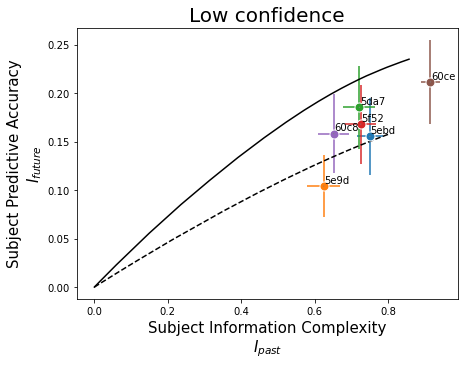

In [88]:
colors = dict(zip(set([key.split("_")[0] for key in ip_h1_boot.keys()]), [cmap(i) for i in np.arange(len(set([key.split("_")[0] for key in ip_h1_boot.keys()])))]))

# Get mean Ipast/Ifuture values per subject
# Low confidence Ipast values and 95% confidence intervals
ip_mean_h1 = np.array([np.mean(ip_h1_boot[key]) for key in ip_h1_boot.keys()])
ip_95CI_h1 = np.array([np.std(ip_h1_boot[key])*1.96 for key in ip_h1_boot.keys()])

# Low confidence Ifuture values and 95% confidence intervals
if_mean_h1 = np.array([np.mean(if_h1_boot[key]) for key in if_h1_boot.keys()])
if_95CI_h1 = np.array([np.std(if_h1_boot[key])*1.96 for key in if_h1_boot.keys()])

h1_subs = np.array([key.split("_")[0] for key in ip_h1_boot.keys()])
h1_colors = np.array([colors[i] for i in h1_subs])

'''
# High confidence Ipast values and 95% confidence intervals
ip_mean_h9 = np.array([np.mean(ip_h9_boot[key]) for key in ip_h9_boot.keys()])
ip_95CI_h9 = np.array([np.std(ip_h9_boot[key])*1.96 for key in ip_h9_boot.keys()])

# High confidence Ifuture values and 95% confidence intervals
if_mean_h9 = np.array([np.mean(if_h9_boot[key]) for key in if_h9_boot.keys()])
if_95CI_h9 = np.array([np.std(if_h9_boot[key])*1.96 for key in if_h9_boot.keys()])

h9_subs = np.array([key.split("_")[0] for key in ip_h9_boot.keys()])
h9_colors = np.array([colors[i] for i in h9_subs])
'''

plt.figure(1,(15,5))
# Low confidence
plt.subplot(1,2,1)
r,p=spearmanr(ip_mean_h1,if_mean_h1)
plt.plot(ipw_h1,ifw_h1,'-k',label='full bound')
plt.plot(ipw_h1_1back,ifw_h1_1back,'--k',label='one-back bound')
for i_p,i_f,col,xe,ye in zip(ip_mean_h1,if_mean_h1,h1_colors, ip_95CI_h1,if_95CI_h1 ):
    plt.errorbar(i_p,i_f,xerr=xe,yerr = ye,
             marker='o',markersize=9,mec='white',color=col,ls='none')
texts = []
for i,sub in enumerate(ip_h1_boot.keys()): 
    texts.append(plt.text(ip_mean_h1[i],if_mean_h1[i],sub))
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
plt.ylabel('Subject Predictive Accuracy\n$I_{future}$',size=15)
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.title('Low confidence',size=20)
#plt.ylim([0,1])

'''
# High confidence
plt.subplot(1,2,2)
r,p=spearmanr(ip_mean_h9,if_mean_h9)
plt.plot(ipw_h9,ifw_h9,'-k',label='full bound')
plt.plot(ipw_h9_1back,ifw_h9_1back,'--k',label='one-back bound')
for i_p,i_f,col,xe,ye in zip(ip_mean_h9,if_mean_h9,h9_colors, ip_95CI_h9,if_95CI_h9):
    plt.errorbar(i_p,i_f,xerr=xe,yerr = ye,
             marker='o',markersize=9,mec='white',color=col,ls='none')
texts = []
for i,sub in enumerate(ip_h9_boot.keys()): 
    texts.append(plt.text(ip_mean_h9[i],if_mean_h9[i],sub))
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.title('High confidence',size=20)
#plt.legend()
#plt.ylim([0,1])
'''

In [193]:
%%time
def get_windowed_mi_subs_confid(sdat_all,nw):
    '''
    Function to compute windowed mutual information values for all subjects
    Input:
        - sdat_all: data frame with all of the subject tones, responses, and sources
        - nw: maximum window size to be considered
    Output:
        - Ipast for each window size and Ifuture
    '''
    # Create dictionaries to keep track of variables with subject IDs as the keys
    subs = pd.unique(sdat_all['Subject'])
    ip_sub = {}
    if_sub = {}    
    # Loop through each subject and get their Ipast for windows up to nw and their ifuture
    for subi,sub in enumerate(subs):
        sdat = sdat_all[sdat_all['Subject'] == sub]                   # Get data from specific subject 
        ip_sub[sub] = get_windowed_mi(sdat['History'],2*sdat['Response'] + sdat['Confidence'],nw, confid = 1)    # compute Ipast using function defined above 
        if_sub[sub] = ut.mutual_inf_nsb(2*sdat['Response'] + sdat['Confidence'],sdat['Jar'],[4,2]) # compute Ifuture
    # Return dictionaries of ipast and ifuture values
    return(ip_sub,if_sub)



def get_bootstrapped_samples_confid(dat,wips,nboot):
    '''
    Function to compute and return bootstrapped distributions of Ipast and Ifuture values for each subject
    Input:
        - dat: all subject data
        - wips: matrix of mutual information by widow size values for each subject
        - nboot: number of requested bootstrap iterations
    Output:
        - dictionaries of bootstrapped distributions of Ipast and Ifuture values
    '''
    # Get subject IDs and initialize dictionaries
    subs = pd.unique(dat['Subject'])
    ip_boot_mi = {}
    if_boot_mi = {}
    
    # Loop through each subject and get bootstrapped estimates
    for subi,sub in enumerate(subs):
        sdat = dat[dat['Subject'] == sub]   # Get subject data
        w = wips[sub].argmax()              # Get subject's maximum window size
        x = np.array(sdat['History'])           # Get tones, responses, and sources for the subject
        r = np.array(2*sdat['Response'] + sdat['Confidence'])
        z = np.array(sdat['Jar'])
        xw,rw = get_windowed_x_v(['0' + h[-(w+1):] for h in x],r,w=(w+1)) # Window the tones and responses appropriately
        ip_boot_mi[sub] = np.zeros(nboot)      # Initialize arrays of mutual information values
        if_boot_mi[sub] = np.zeros(nboot)
            
        # Run bootstrap procedure
        for boot in np.arange(nboot):
            idx = np.random.choice(np.arange(len(xw)),size=len(xw),replace=True)    # Select random indicies with replacement
            ip_boot_mi[sub][boot] = ut.mutual_inf_nsb(xw[idx],rw[idx],[2**(w+1),4]) # Use indexed data to compute Ipast
            if_boot_mi[sub][boot] = ut.mutual_inf_nsb(r[idx],z[idx],[4,2])
    # Return dictionaries of Ipast and Ifuture distributions
    return(ip_boot_mi,if_boot_mi)

CPU times: user 12 µs, sys: 1 µs, total: 13 µs
Wall time: 16.2 µs


In [190]:
%%time
def get_windowed_mi_subs_confid_r(sdat_all,nw):
    '''
    Function to compute windowed mutual information values for all subjects
    Input:
        - sdat_all: data frame with all of the subject tones, responses, and sources
        - nw: maximum window size to be considered
    Output:
        - Ipast for each window size and Ifuture
    '''
    # Create dictionaries to keep track of variables with subject IDs as the keys
    subs = pd.unique(sdat_all['Subject'])
    ip_sub = {}
    if_sub = {}    
    # Loop through each subject and get their Ipast for windows up to nw and their ifuture
    for subi,sub in enumerate(subs):
        sdat = sdat_all[sdat_all['Subject'] == sub]                   # Get data from specific subject 
        ip_sub[sub] = get_windowed_mi(sdat['History'].reset_index(drop = True),2*sdat['Response'].reset_index(drop = True) + (sdat['Confidence'][500:].append(sdat['Confidence'][:500]).reset_index(drop = True)),nw, confid = 1)    # compute Ipast using function defined above 
        if_sub[sub] = ut.mutual_inf_nsb(2*sdat['Response'].reset_index(drop = True) + (sdat['Confidence'][500:].append(sdat['Confidence'][:500]).reset_index(drop = True)),sdat['Jar'].reset_index(drop = True),[4,2]) # compute Ifuture
    # Return dictionaries of ipast and ifuture values
    return(ip_sub,if_sub)

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 10 µs


<Figure size 1080x360 with 0 Axes>

<AxesSubplot:>

Text(0, 0.5, 'Subject $I_{past}$')

Text(0.5, 0, 'Window size of $X$ into the past')

Text(0.5, 1.0, 'Low confidence')

Text(0, 0.5, 'Subject $I_{past}$')

Text(0.5, 0, 'Window size of $X$ into the past')

Text(0.5, 1.0, 'Low confidence')

Text(0, 0.5, 'Subject $I_{past}$')

Text(0.5, 0, 'Window size of $X$ into the past')

Text(0.5, 1.0, 'Low confidence')

Text(0, 0.5, 'Subject $I_{past}$')

Text(0.5, 0, 'Window size of $X$ into the past')

Text(0.5, 1.0, 'Low confidence')

Text(0, 0.5, 'Subject $I_{past}$')

Text(0.5, 0, 'Window size of $X$ into the past')

Text(0.5, 1.0, 'Low confidence')

Text(0, 0.5, 'Subject $I_{past}$')

Text(0.5, 0, 'Window size of $X$ into the past')

Text(0.5, 1.0, 'Low confidence')

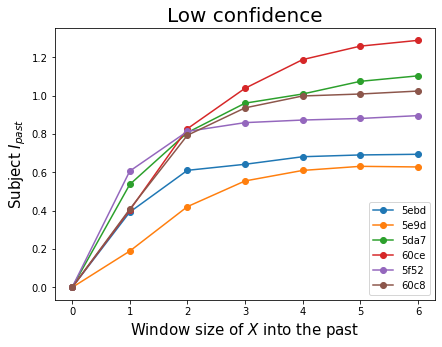

In [199]:
ips_sub_confid, if_sub_confid = get_windowed_mi_subs_confid(D,6)

plt.figure(1,(15,5))
# Low confidence
plt.subplot(1,2,1)
for sub in pd.unique([key for key in ips_sub_confid.keys()]):
    plt.plot(np.arange(len(ips_sub_confid[sub])),ips_sub_confid[sub],'-o',label = sub)
    plt.ylabel('Subject $I_{past}$',size=15)
    plt.xlabel('Window size of $X$ into the past',size=15)
    plt.title('Low confidence',size=20)
    #plt.ylim([0,1])
    plt.legend(loc = 'lower right')
    

In [92]:
nboot = 1000 #number of bootstrapped samples
    #Low confidence
ip_confid_boot, if_confid_boot = get_bootstrapped_samples_confid(D,ips_sub_confid,nboot)

<Figure size 2160x720 with 0 Axes>

<AxesSubplot:>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

6

Text(236.625, 0.5, 'Subject Predictive Accuracy\n$I_{future}$')

Text(0.5, 69.0, 'Subject Information Complexity\n$I_{past}$')

Text(0.5, 1.0, 'Decision only vs decision + confidence')

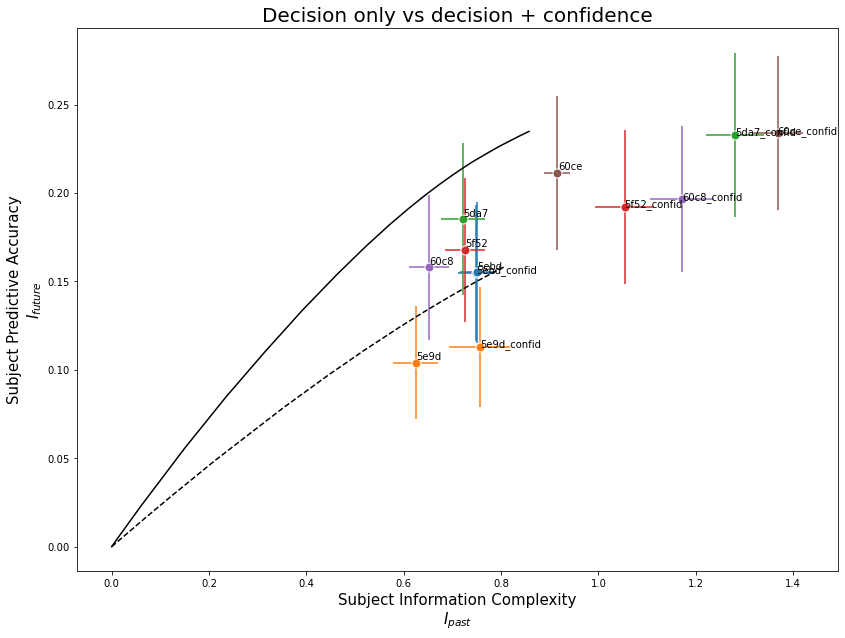

In [209]:
colors = dict(zip(set([key.split("_")[0] for key in ip_confid_boot.keys()]), [cmap(i) for i in np.arange(len(set([key.split("_")[0] for key in ip_confid_boot.keys()])))]))

# Get mean Ipast/Ifuture values per subject
# Low confidence Ipast values and 95% confidence intervals
ip_mean_confid = np.array([np.mean(ip_confid_boot[key]) for key in ip_confid_boot.keys()])
ip_95CI_confid = np.array([np.std(ip_confid_boot[key])*1.96 for key in ip_confid_boot.keys()])

# Low confidence Ifuture values and 95% confidence intervals
if_mean_confid = np.array([np.mean(if_confid_boot[key]) for key in if_confid_boot.keys()])
if_95CI_confid = np.array([np.std(if_confid_boot[key])*1.96 for key in if_confid_boot.keys()])

confid_subs = np.array([key.split("_")[0] for key in ip_confid_boot.keys()])
confid_colors = np.array([colors[i] for i in confid_subs])


plt.figure(1,(30,10))
# Low confidence
plt.subplot(1,2,1)
r,p=spearmanr(ip_mean_confid,if_mean_confid)
plt.plot(ipw_h1,ifw_h1,'-k',label='full bound')
plt.plot(ipw_h1_1back,ifw_h1_1back,'--k',label='one-back bound')
for i_p,i_f,col,xe,ye in zip(ip_mean_confid,if_mean_confid,confid_colors, ip_95CI_confid,if_95CI_confid ):
    plt.errorbar(i_p,i_f,xerr=xe,yerr = ye,
             marker='o',markersize=9,mec='white',color=col,ls='none')
texts = []
for i,sub in enumerate(ip_confid_boot.keys()): 
    texts.append(plt.text(ip_mean_confid[i],if_mean_confid[i],sub+"_confid"))
    
for i_p,i_f,col,xe,ye in zip(ip_mean_h1,if_mean_h1,h1_colors, ip_95CI_h1,if_95CI_h1 ):
    plt.errorbar(i_p,i_f,xerr=xe,yerr = ye,
             marker='o',markersize=9,mec='white',color=col,ls='none')
texts = []
for i,sub in enumerate(ip_h1_boot.keys()): 
    texts.append(plt.text(ip_mean_h1[i],if_mean_h1[i],sub))
    
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'), size = 15)
plt.ylabel('Subject Predictive Accuracy\n$I_{future}$',size=15)
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.title('Decision only vs decision + confidence',size=20)
#plt.ylim([0,1])

In [57]:
D['Subject'].unique()

array(['5fac', '5d6f', '598b', '6041', '5eb1'], dtype=object)

In [201]:
%%time
def get_windowed_mi_subs_confo(sdat_all,nw):
    '''
    Function to compute windowed mutual information values for all subjects
    Input:
        - sdat_all: data frame with all of the subject tones, responses, and sources
        - nw: maximum window size to be considered
    Output:
        - Ipast for each window size and Ifuture
    '''
    # Create dictionaries to keep track of variables with subject IDs as the keys
    subs = pd.unique(sdat_all['Subject'])
    ip_sub = {}
    if_sub = {}
    # Loop through each subject and get their Ipast for windows up to nw and their ifuture
    for subi,sub in enumerate(subs):
        sdat = sdat_all[sdat_all['Subject'] == sub]                   # Get data from specific subject 
        ip_sub[sub] = get_windowed_mi(sdat['History'],sdat['Confidence'],nw)    # compute Ipast using function defined above 
        if_sub[sub] = ut.mutual_inf_nsb(sdat['Confidence'],sdat['Jar'],[2,2]) # compute Ifuture
    # Return dictionaries of ipast and ifuture values
    return(ip_sub,if_sub)

def get_bootstrapped_samples_confo(dat,wips,nboot):
    '''
    Function to compute and return bootstrapped distributions of Ipast and Ifuture values for each subject
    Input:
        - dat: all subject data
        - wips: matrix of mutual information by widow size values for each subject
        - nboot: number of requested bootstrap iterations
    Output:
        - dictionaries of bootstrapped distributions of Ipast and Ifuture values
    '''
    # Get subject IDs and initialize dictionaries
    subs = pd.unique(dat['Subject'])
    ip_boot_mi = {}
    if_boot_mi = {}
    
    # Loop through each subject and get bootstrapped estimates
    for subi,sub in enumerate(subs):
        sdat = dat[dat['Subject'] == sub]   # Get subject data
        w = wips[sub].argmax()              # Get subject's maximum window size
        x = np.array(sdat['History'])           # Get tones, responses, and sources for the subject
        r = np.array(sdat['Confidence'])
        z = np.array(sdat['Jar'])
        xw,rw = get_windowed_x_v(['0' + h[-(w+1):] for h in x],r,w=(w+1)) # Window the tones and responses appropriately
        ip_boot_mi[sub] = np.zeros(nboot)      # Initialize arrays of mutual information values
        if_boot_mi[sub] = np.zeros(nboot)
            
        # Run bootstrap procedure
        for boot in np.arange(nboot):
            idx = np.random.choice(np.arange(len(xw)),size=len(xw),replace=True)    # Select random indicies with replacement
            ip_boot_mi[sub][boot] = ut.mutual_inf_nsb(xw[idx],rw[idx],[2**(w+1),2]) # Use indexed data to compute Ipast
            if_boot_mi[sub][boot] = ut.mutual_inf_nsb(r[idx],z[idx],[2,2])
    # Return dictionaries of Ipast and Ifuture distributions
    return(ip_boot_mi,if_boot_mi)

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 13.8 µs


In [202]:
ips_sub_confo, if_sub_confo = get_windowed_mi_subs_confo(D,6)

nboot = 1000 #number of bootstrapped samples
    #Low confidence
ip_confo_boot, if_confo_boot = get_bootstrapped_samples_confo(D,ips_sub_confo,nboot)

ip_mean_confo = np.array([np.mean(ip_confo_boot[key]) for key in ip_confo_boot.keys()])
ip_95CI_confo = np.array([np.std(ip_confo_boot[key])*1.96 for key in ip_confo_boot.keys()])

<Figure size 2160x720 with 0 Axes>

<AxesSubplot:>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

6

Text(236.625, 0.5, 'Subject Predictive Accuracy\n$I_{future}$')

Text(0.5, 69.0, 'Subject Information Complexity\n$I_{past}$')

Text(0.5, 1.0, 'Decision only vs decision + confidence')

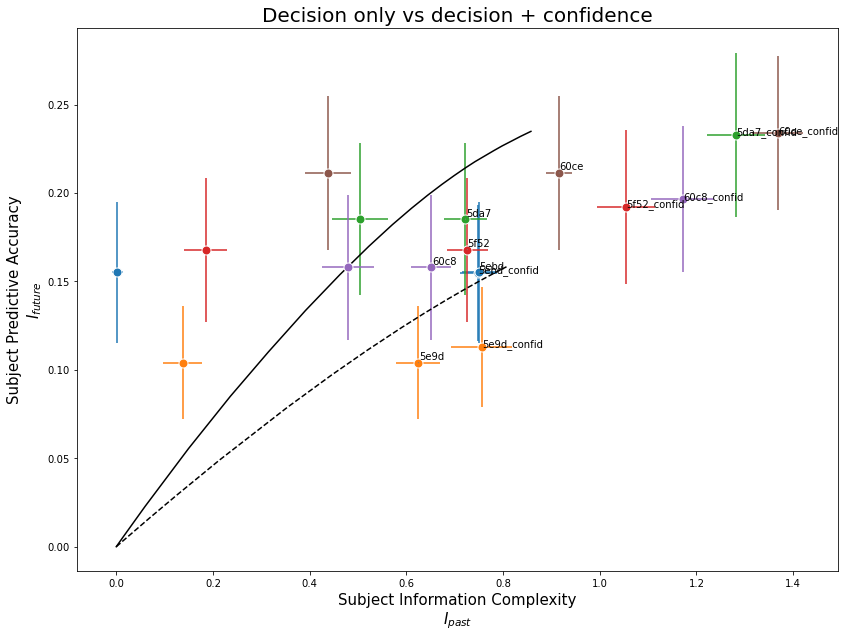

In [203]:
plt.figure(1,(30,10))
# Low confidence
plt.subplot(1,2,1)
r,p=spearmanr(ip_mean_confid,if_mean_confid)
plt.plot(ipw_h1,ifw_h1,'-k',label='full bound')
plt.plot(ipw_h1_1back,ifw_h1_1back,'--k',label='one-back bound')
for i_p,i_f,col,xe,ye in zip(ip_mean_confid,if_mean_confid,confid_colors, ip_95CI_confid,if_95CI_confid ):
    plt.errorbar(i_p,i_f,xerr=xe,yerr = ye,
             marker='o',markersize=9,mec='white',color=col,ls='none')
texts = []
for i,sub in enumerate(ip_confid_boot.keys()): 
    texts.append(plt.text(ip_mean_confid[i],if_mean_confid[i],sub+"_confid"))
    
for i_p,i_f,col,xe,ye in zip(ip_mean_h1,if_mean_h1,h1_colors, ip_95CI_h1,if_95CI_h1 ):
    plt.errorbar(i_p,i_f,xerr=xe,yerr = ye,
             marker='o',markersize=9,mec='white',color=col,ls='none')
texts = []
for i,sub in enumerate(ip_h1_boot.keys()): 
    texts.append(plt.text(ip_mean_h1[i],if_mean_h1[i],sub))
    
for i_p,i_f,col,xe,ye in zip(ip_mean_confo,if_mean_h1,h1_colors, ip_95CI_confo,if_95CI_h1 ):
    plt.errorbar(i_p,i_f,xerr=xe,yerr = ye,
             marker='o',markersize=9,mec='white',color=col,ls='none')
    
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
plt.ylabel('Subject Predictive Accuracy\n$I_{future}$',size=15)
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.title('Decision only vs decision + confidence',size=20)
#plt.ylim([0,1])

In [206]:
ip_mean_confo
ip_mean_h1
ip_mean_confid
ip_mean_confo + ip_mean_h1

array([0.00245995, 0.13721896, 0.50405744, 0.43715886, 0.18455339,
       0.47906865])

array([0.75049954, 0.62466483, 0.72186623, 0.91581781, 0.72592608,
       0.65177328])

array([0.74897283, 0.75613068, 1.28146731, 1.36823183, 1.05361684,
       1.17169403])

array([0.75295949, 0.76188379, 1.22592366, 1.35297667, 0.91047947,
       1.13084193])

In [211]:
#D.to_csv("./PilotData4_munged.csv", index=False)

In [215]:
type(D['History'][1])

str

In [217]:
ip_95CI_confo

array([0.01199113, 0.04000728, 0.05691315, 0.04746731, 0.04356659,
       0.0542495 ])

In [219]:
{key: np.mean(ip_h1_boot[key]) for key in ip_h1_boot.keys()}

{'5ebd': 0.750499539701528,
 '5e9d': 0.6246648265004648,
 '5da7': 0.7218662298360821,
 '60ce': 0.9158178095247776,
 '5f52': 0.725926075903613,
 '60c8': 0.6517732786060451}

In [ ]:
%%time
def get_windowed_mi_subs_confid(sdat_all,nw):
    '''
    Function to compute windowed mutual information values for all subjects
    Input:
        - sdat_all: data frame with all of the subject tones, responses, and sources
        - nw: maximum window size to be considered
    Output:
        - Ipast for each window size and Ifuture
    '''
    # Create dictionaries to keep track of variables with subject IDs as the keys
    subs = pd.unique(sdat_all['Subject'])
    ip_sub = {}
    # Loop through each subject and get their Ipast for windows up to nw and their ifuture
    for subi,sub in enumerate(subs):
        sdat = sdat_all[sdat_all['Subject'] == sub]                   # Get data from specific subject 
        ip_sub[sub] = get_windowed_mi(sdat['History'],sdat['Response'],nw, confid = 1)    # compute Ipast using function defined above 
    # Return dictionaries of ipast and ifuture values
    return(ip_sub)


def get_bootstrapped_samples_confid(dat,wips,nboot):
    '''
    Function to compute and return bootstrapped distributions of Ipast and Ifuture values for each subject
    Input:
        - dat: all subject data
        - wips: matrix of mutual information by widow size values for each subject
        - nboot: number of requested bootstrap iterations
    Output:
        - dictionaries of bootstrapped distributions of Ipast and Ifuture values
    '''
    # Get subject IDs and initialize dictionaries
    subs = pd.unique(dat['Subject'])
    ip_boot_mi = {}
    
    # Loop through each subject and get bootstrapped estimates
    for subi,sub in enumerate(subs):
        sdat = dat[dat['Subject'] == sub]   # Get subject data
        w = wips[sub].argmax()              # Get subject's maximum window size
        x = np.array(sdat['History'])           # Get tones, responses, and sources for the subject
        r = np.array(2*sdat['Response'] + sdat['Confidence'])
        z = np.array(sdat['Jar'])
        xw,rw = get_windowed_x_v(['0' + h[-(w+1):] for h in x],r,w=(w+1)) # Window the tones and responses appropriately
        ip_boot_mi[sub] = np.zeros(nboot)      # Initialize arrays of mutual information values
        
        # Run bootstrap procedure
        for boot in np.arange(nboot):
            idx = np.random.choice(np.arange(len(xw)),size=len(xw),replace=True)    # Select random indicies with replacement
            ip_boot_mi[sub][boot] = ut.mutual_inf_nsb(xw[idx],rw[idx],[2**(w+1),4]) # Use indexed data to compute Ipast
    # Return dictionaries of Ipast and Ifuture distributions
    return(ip_boot_mi)

In [ ]:
#try:
    # Check if subject mutual information values have already been computed
#    ips_sub_h1,if_sub_h1 = pickle.load(open('vickie_sim_mar9_ipf_sub_h1.pkl','rb')) #load windowed mutual information values for H=.01
#    ips_sub_h9,if_sub_h9 = pickle.load(open('vickie_sim_mar9_ipf_sub_h9.pkl','rb')) #load windowed mutual information values for H=.99
#except:
    # If not, compute them below
    # Low confidence
ips_sub_confid = get_windowed_mi_subs_confid(D,10)
    #pickle.dump((ips_sub_h1,if_sub_h1),open('vickie_sim_mar9_ipf_sub_h1.pkl','wb'))

#try:
    # Check to see if bootstrapped samples have already been computed
#    ip_h1_boot, if_h1_boot = pickle.load(open('vickie_sim_mar9_ip_if_h1_boot.pkl','rb')) # Low confidence
#    ip_h9_boot, if_h9_boot = pickle.load(open('vickie_sim_mar9_ip_if_h9_boot.pkl','rb')) # High confidence
#except:
    # If not, compute and save below
nboot = 1000 #number of bootstrapped samples
    #Low confidence
ip_confid_boot = get_bootstrapped_samples_confid(D,ips_sub_confid,nboot)
    #pickle.dump((ip_h1_boot, if_h1_boot),open('vickie_sim_mar9_ip_if_h1_boot.pkl','wb'))

In [ ]:
%%time
def get_windowed_mi_subs_confid_only(sdat_all,nw):
    '''
    Function to compute windowed mutual information values for all subjects
    Input:
        - sdat_all: data frame with all of the subject tones, responses, and sources
        - nw: maximum window size to be considered
    Output:
        - Ipast for each window size and Ifuture
    '''
    # Create dictionaries to keep track of variables with subject IDs as the keys
    subs = pd.unique(sdat_all['Subject'])
    ip_sub = {}
    # Loop through each subject and get their Ipast for windows up to nw and their ifuture
    for subi,sub in enumerate(subs):
        sdat = sdat_all[sdat_all['Subject'] == sub]                   # Get data from specific subject 
        ip_sub[sub] = get_windowed_mi(sdat['History'],sdat['Confidence'],nw)    # compute Ipast using function defined above 
    # Return dictionaries of ipast and ifuture values
    return(ip_sub)


def get_bootstrapped_samples_confid_only(dat,wips,nboot):
    '''
    Function to compute and return bootstrapped distributions of Ipast and Ifuture values for each subject
    Input:
        - dat: all subject data
        - wips: matrix of mutual information by widow size values for each subject
        - nboot: number of requested bootstrap iterations
    Output:
        - dictionaries of bootstrapped distributions of Ipast and Ifuture values
    '''
    # Get subject IDs and initialize dictionaries
    subs = pd.unique(dat['Subject'])
    ip_boot_mi = {}
    
    # Loop through each subject and get bootstrapped estimates
    for subi,sub in enumerate(subs):
        sdat = dat[dat['Subject'] == sub]   # Get subject data
        w = wips[sub].argmax()              # Get subject's maximum window size
        x = np.array(sdat['History'])           # Get tones, responses, and sources for the subject
        r = np.array(sdat['Confidence'])
        z = np.array(sdat['Jar'])
        xw,rw = get_windowed_x_v(['0' + h[-(w+1):] for h in x],r,w=(w+1)) # Window the tones and responses appropriately
        ip_boot_mi[sub] = np.zeros(nboot)      # Initialize arrays of mutual information values
        
        # Run bootstrap procedure
        for boot in np.arange(nboot):
            idx = np.random.choice(np.arange(len(xw)),size=len(xw),replace=True)    # Select random indicies with replacement
            ip_boot_mi[sub][boot] = ut.mutual_inf_nsb(xw[idx],rw[idx],[2**(w+1),2]) # Use indexed data to compute Ipast
    # Return dictionaries of Ipast and Ifuture distributions
    return(ip_boot_mi)

In [1247]:
ips_sub_confid_only = get_windowed_mi_subs_confid_only(D[D['Subject'].str.find("_") == -1],10)
ip_confid_only_boot = get_bootstrapped_samples_confid_only(D[D['Subject'].str.find("_") == -1],ips_sub_confid_only,nboot)

In [1152]:
ip_mean_confid = np.array([np.mean(ip_confid_boot[key]) for key in ip_confid_boot.keys()])
ip_95CI_confid = np.array([np.std(ip_confid_boot[key])*1.96 for key in ip_confid_boot.keys()])

In [ ]:
ip_noconfid, if_noconfid = get_bootstrapped_samples(D[D['Subject'].str.find("_") == -1],ips_sub_h1,nboot)
ip_mean_noconfid = np.array([np.mean(ip_noconfid[key]) for key in ip_noconfid.keys()])

In [1248]:
ip_mean_confid_only = np.array([np.mean(ip_confid_only_boot[key]) for key in ip_confid_only_boot.keys()])

In [1154]:
ip_mean_confid

array([0.45329015, 1.12133796, 0.58585388, 1.01932459, 0.60863374,
       0.686839  , 0.40259199, 1.53888557, 0.91101466, 0.71532023,
       0.50919126, 1.35946231, 0.76742958, 0.63015836, 0.4217495 ])

In [1249]:
ip_mean_confid_only 

array([0.15311323, 0.33136504, 0.02612676, 0.29493106, 0.07373036])

In [1250]:
D['Subject'].unique()

array(['5fac', '5d6f', '598b', '5eb1', '6041', '5fac_Ideal',
       '5fac_Random', '5d6f_Ideal', '5d6f_Random', '598b_Ideal',
       '598b_Random', '5eb1_Ideal', '5eb1_Random', '6041_Ideal',
       '6041_Random'], dtype=object)

In [1246]:
ip_mean_confid_only

array([ 1.53201152e-01,  3.32205700e-01,  2.65794211e-02,  2.94775838e-01,
        7.22308354e-02,  4.66396968e-01,  1.08118143e-01,  7.74725873e-01,
        1.27843386e-01,  4.74655201e-01,  1.28961599e-01, -1.87103595e+03,
        1.24828445e-01,  3.55617308e-01,  8.51309375e-02])

In [1165]:
[k for k in ip_confid_boot.keys()]

['5fac',
 '5d6f',
 '598b',
 '5eb1',
 '6041',
 '5fac_Ideal',
 '5fac_Random',
 '5d6f_Ideal',
 '5d6f_Random',
 '598b_Ideal',
 '598b_Random',
 '5eb1_Ideal',
 '5eb1_Random',
 '6041_Ideal',
 '6041_Random']

In [1158]:
h1_colors

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ]])

<Figure size 576x432 with 0 Axes>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

8

Text(35.5, 0.5, 'Subject$')

Text(0.5, 33.0, 'Information Complexity\n$I_{past}$')

Text(0.5, 1.0, 'Low confidence')

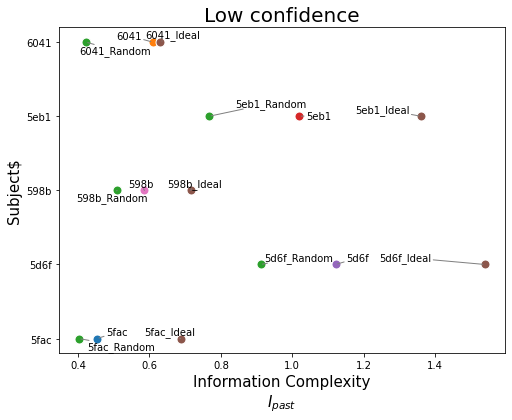

In [1252]:
colors = dict(zip(set([key.split("_")[-1] for key in ip_confid_boot.keys()]), [cmap(i) for i in np.arange(len(set([key.split("_")[-1] for key in ip_confid_boot.keys()])))]))

confid_subs = np.array([key.split("_")[-1] for key in ip_confid_boot.keys()])
confid_colors = np.array([colors[i] for i in confid_subs])

plt.figure(1,(8,6))
#plt.errorbar(ip_mean_noconfid + ip_mean_confid_only, [key for key in ip_noconfid.keys()], marker = 's',ls='none')
for i_p,sub,col,ye in zip(ip_mean_confid, [key.split("_")[0] for key in ip_confid_boot.keys()],confid_colors,ip_95CI_confid):
    plt.errorbar([i_p],[sub],
             marker='o',markersize=9,mec='white',color = col,ls='none')
texts = []
for i,sub in enumerate(ip_confid_boot.keys()): 
    texts.append(plt.text(ip_mean_confid[i],[sub.split("_")[0]],sub))
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
plt.ylabel('Subject$',size=15)
plt.xlabel('Information Complexity\n$I_{past}$',size=15)
plt.title('Low confidence',size=20)


In [1205]:
colors

{'5fac': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 '6041': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 'Random': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 '5eb1': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 '5d6f': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 'Ideal': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
 '598b': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0)}

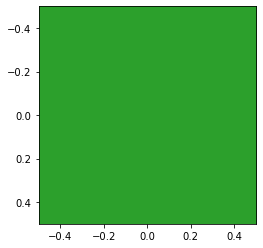

In [1214]:
plt.imshow([[[0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0]]])

In [1185]:
for i_p,sub,col,ye in zip(ip_mean_confid, [key.split("_")[0] for key in ip_confid_boot.keys()],confid_colors,ip_95CI_confid):
    print([i_p,sub,col,ye])

[0.4532901502166177, '5fac', array([0.12156863, 0.46666667, 0.70588235, 1.        ]), 0.05966175425415952]
[1.1213379609428513, '5d6f', array([0.58039216, 0.40392157, 0.74117647, 1.        ]), 0.06943378218109339]
[0.5858538812612019, '598b', array([0.89019608, 0.46666667, 0.76078431, 1.        ]), 0.060003477402614296]
[1.0193245880304214, '5eb1', array([0.83921569, 0.15294118, 0.15686275, 1.        ]), 0.05631598048242656]
[0.6086337380596565, '6041', array([1.        , 0.49803922, 0.05490196, 1.        ]), 0.058871388859801255]
[0.6868389956138014, '5fac', array([0.54901961, 0.3372549 , 0.29411765, 1.        ]), 0.06956389646430673]
[0.4025919923277545, '5fac', array([0.17254902, 0.62745098, 0.17254902, 1.        ]), 0.05554714977057614]
[1.5388855730916293, '5d6f', array([0.54901961, 0.3372549 , 0.29411765, 1.        ]), 0.05818982735859251]
[0.91101466068325, '5d6f', array([0.17254902, 0.62745098, 0.17254902, 1.        ]), 0.06244843204369425]
[0.7153202320180446, '598b', array([0

In [1169]:
len([k for k in ip_confid_boot.keys()])

15

In [1171]:
for t in zip(ip_mean_confid,[k for k in ip_confid_boot.keys()],h1_colors, ip_95CI_confid):
    print(t)

(0.4532901502166177, '5fac', array([0.12156863, 0.46666667, 0.70588235, 1.        ]), 0.05966175425415952)
(1.1213379609428513, '5d6f', array([0.83921569, 0.15294118, 0.15686275, 1.        ]), 0.06943378218109339)
(0.5858538812612019, '598b', array([0.58039216, 0.40392157, 0.74117647, 1.        ]), 0.060003477402614296)
(1.0193245880304214, '5eb1', array([0.17254902, 0.62745098, 0.17254902, 1.        ]), 0.05631598048242656)
(0.6086337380596565, '6041', array([1.        , 0.49803922, 0.05490196, 1.        ]), 0.058871388859801255)
(0.6868389956138014, '5fac_Ideal', array([0.12156863, 0.46666667, 0.70588235, 1.        ]), 0.06956389646430673)
(0.4025919923277545, '5fac_Random', array([0.12156863, 0.46666667, 0.70588235, 1.        ]), 0.05554714977057614)
(1.5388855730916293, '5d6f_Ideal', array([0.83921569, 0.15294118, 0.15686275, 1.        ]), 0.05818982735859251)
(0.91101466068325, '5d6f_Random', array([0.83921569, 0.15294118, 0.15686275, 1.        ]), 0.06244843204369425)
(0.71532023

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History
0,5fac,10,0,0,1,1,0,00001001010
1,5fac,11,0,0,0,1,1,00010010100
2,5fac,12,0,0,0,1,1,00100101000
3,5fac,13,0,0,0,1,1,01001010000
4,5fac,14,0,1,0,1,0,00010100000
...,...,...,...,...,...,...,...,...
4995,6041,1005,1,1,1,1,1,00101111111
4996,6041,1006,1,0,1,1,0,01011111111
4997,6041,1007,1,0,1,1,0,00111111110
4998,6041,1008,1,0,0,0,1,01111111100


In [1041]:
h1_subs = np.array([key.split("_")[0] for key in ip_h1_boot.keys()])
h1_subs

array(['605e', '5ce7', '5de0', 'Ideal2', '605e', '605e', '5ce7', '5ce7',
       '5de0', '5de0'], dtype='<U6')

In [1066]:
h1_colors

array([[1.        , 0.49803922, 0.05490196, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.12156863, 0.46666667, 0.70588235, 1.        ]])

In [1067]:
ipw_h1_1back

array([3.15947268e-12, 1.27307054e-11, 2.85997892e-11, ...,
       9.98263879e-01, 9.98263879e-01, 9.98263879e-01])

In [1034]:
[cmap(i) for i in np.arange(len(set([key.split("_")[0] for key in ip_h1_boot.keys()])))]

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)]

In [1053]:
colors[h1_subs[1]]

(0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)

In [1008]:
[cmap(i) for i in np.arange(4)]

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)]

In [1025]:
a = [key.split("_")[0] for key in ip_h1_boot.keys()]
set(a)

{'5ce7', '5de0', '605e', 'Ideal2'}

In [575]:
if_mean_h1

array([0.03131441, 0.28551992, 0.0006113 ])

In [576]:
if_mean_h9

array([0.03115361, 0.75399935, 0.7101457 ])

In [651]:
adat_trials

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History
1000,5ce7c46d79642d0017767d94,10,1,1,1,0,1,00000000000
1001,5ce7c46d79642d0017767d94,11,1,1,1,0,1,00000000001
1002,5ce7c46d79642d0017767d94,12,1,1,1,1,1,00000000011
1003,5ce7c46d79642d0017767d94,13,1,1,1,1,1,00000000111
1004,5ce7c46d79642d0017767d94,14,1,1,1,1,1,00000001111
...,...,...,...,...,...,...,...,...
1995,5ce7c46d79642d0017767d94,1005,1,1,1,1,1,01111111111
1996,5ce7c46d79642d0017767d94,1006,1,1,1,1,1,01111111111
1997,5ce7c46d79642d0017767d94,1007,1,1,1,1,1,01111111111
1998,5ce7c46d79642d0017767d94,1008,1,1,1,1,1,01111111111


In [ ]:
## Plot accuracy bar overall

## Plot accuracy bar split over confidence

## Plot accuracy bar split over hazard

## Plot accuracy bar split over both

## Plot confidence bar overall

## Plot confidence bar split over hazard

## Plot confidence bar split over correct

## Plot confidence bar split over both

In [ ]:
plt.figure(1,(15,6))

## Plot accuracy bar overall
plt.subplot(1,2,1)
sns.barplot(y="Subject", x="Correct", 
            data=D[['Subject','Correct']].groupby(['Subject'],as_index=False).mean())
#plt.ylim([0,1])
plt.xlabel('Accuracy',size=15)
plt.ylabel('Subject',size=15)
plt.xlim([-.05,1.05])
plt.tight_layout()

## Plot confidence bar overall
plt.subplot(1,2,2)
sns.barplot(y="Subject", x="Confidence", 
            data=D[['Subject','Confidence']].groupby(['Subject'],as_index=False).mean())
plt.axvline(x=1, ls = '--')
#plt.ylim([0,1])
plt.xlabel('Proportion High Confidence',size=15)
plt.ylabel('Subject',size=15)
plt.xlim([-.05,1.05])
plt.tight_layout()

<Figure size 1080x432 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='Correct', ylabel='Subject'>

Text(0.5, 0, 'Accuracy')

Text(0, 0.5, 'Subject')

<AxesSubplot:>

KeyError: "['H'] not in index"

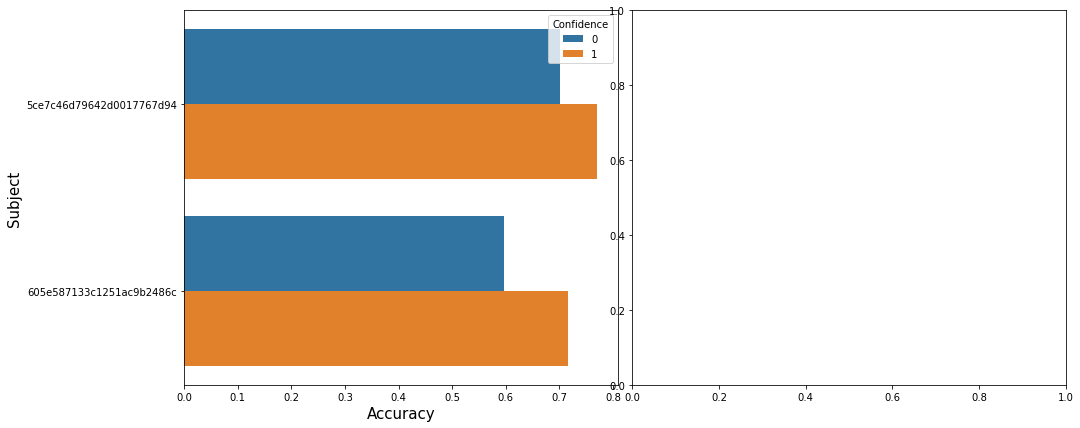

In [66]:
## Plot accuracy bar split over confidence and accuracy bar split over hazard
plt.figure(1,(15,6))
# Accuracy split by confidence
plt.subplot(1,2,1)
sns.barplot(y="Subject", x="Correct", hue="Confidence", 
            data=D[['Subject','Correct','Confidence']].groupby(['Subject','Confidence'],as_index=False).mean())
#plt.ylim([0,1])
plt.xlabel('Accuracy',size=15)
plt.ylabel('Subject',size=15)
plt.tight_layout()

# Accuracy split by hazard
plt.subplot(1,2,2)
sns.barplot(y="Subject", x="Correct", hue="H", 
            data=D[['Subject','Correct','H']].groupby(['Subject','H'],as_index=False).mean())
#plt.ylim([0,1])
plt.xlabel('Accuracy',size=15)
plt.ylabel('Subject',size=15)
plt.tight_layout()

<Figure size 1080x432 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='Confidence', ylabel='Subject'>

Text(0.5, 0, 'Proportion High Confidence')

Text(0, 0.5, 'Subject')

<AxesSubplot:>

<AxesSubplot:xlabel='Confidence', ylabel='Subject'>

Text(0.5, 0, 'Proportion High Confidence')

Text(0, 0.5, 'Subject')

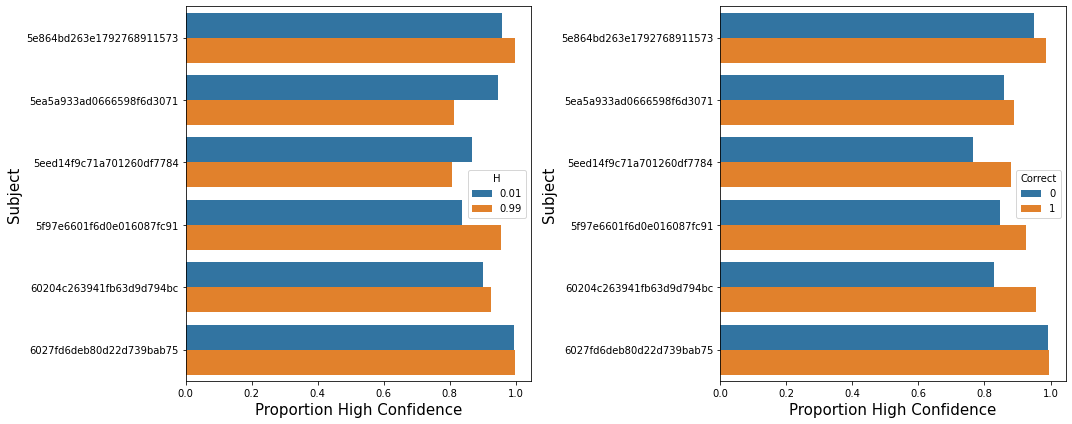

In [348]:
## Plot confidence bar split over hazard and confidence bar split over correctness
plt.figure(1,(15,6))
# Confidence split by hazard
plt.subplot(1,2,1)
sns.barplot(y="Subject", x="Confidence", hue="H", 
            data=D[['Subject','H','Confidence']].groupby(['Subject','H'],as_index=False).mean())
#plt.ylim([0,1])
plt.xlabel('Proportion High Confidence',size=15)
plt.ylabel('Subject',size=15)
plt.tight_layout()

# Confidence split by correctness
plt.subplot(1,2,2)
sns.barplot(y="Subject", x="Confidence", hue="Correct", 
            data=D[['Subject','Correct','Confidence']].groupby(['Subject','Correct'],as_index=False).mean())
#plt.ylim([0,1])
plt.xlabel('Proportion High Confidence',size=15)
plt.ylabel('Subject',size=15)
plt.tight_layout()

<Figure size 576x432 with 0 Axes>

[None, None]

<Figure size 576x432 with 0 Axes>

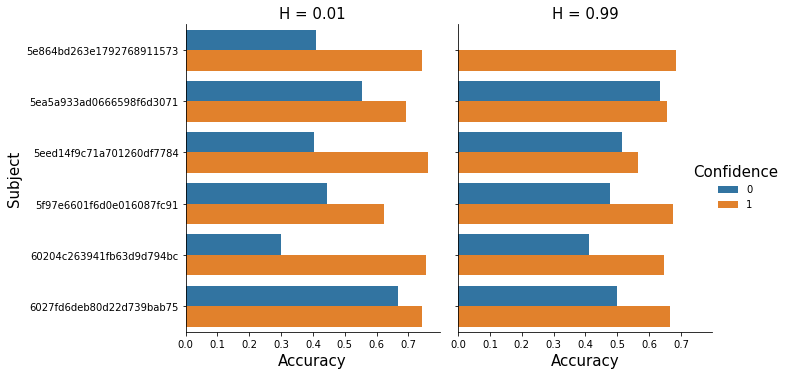

In [344]:
## Plot accuracy bar split over both
plt.figure(1,(8,6))
accuracy_H_confid = sns.catplot(y="Subject", x="Correct", hue="Confidence", col="H", kind="bar",
            data=D[['Subject','Correct','Confidence','H']].groupby(['Subject','Confidence','H'],as_index=False).mean())
#plt.ylim([0,1])
accuracy_H_confid.set_xlabels('Accuracy',size=15)
accuracy_H_confid.set_ylabels('Subject',size=15)
accuracy_H_confid.set_titles(size=15)
plt.setp(accuracy_H_confid._legend.get_title(), fontsize=15)
plt.show()

<Figure size 576x432 with 0 Axes>

[None, None]

<Figure size 576x432 with 0 Axes>

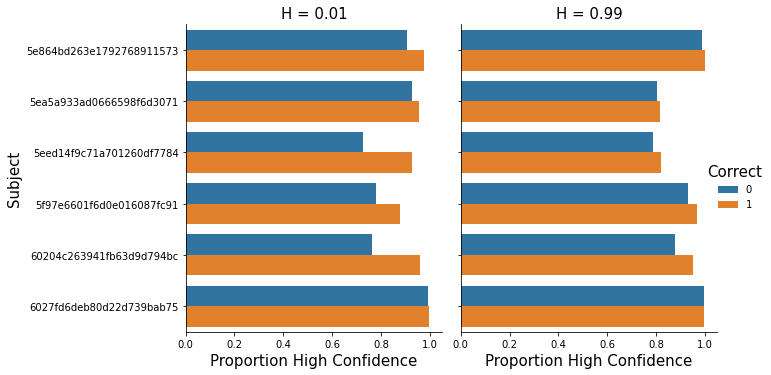

In [349]:
## Plot confidence bar split over both
plt.figure(1,(8,6))
accuracy_H_confid = sns.catplot(y="Subject", x="Confidence", hue="Correct", col="H", kind="bar",
            data=D[['Subject','Correct','Confidence','H']].groupby(['Subject','Correct','H'],as_index=False).mean())
#plt.ylim([0,1])
accuracy_H_confid.set_xlabels('Proportion High Confidence',size=15)
accuracy_H_confid.set_ylabels('Subject',size=15)
accuracy_H_confid.set_titles(size=15)
plt.setp(accuracy_H_confid._legend.get_title(), fontsize=15)
plt.show()

In [350]:
D[['Subject','Correct']].groupby(['Subject'],as_index=False).mean()
D[['Subject','Correct','H']].groupby(['Subject','H'],as_index=False).mean()

D[['Subject','Confidence']].groupby(['Subject'],as_index=False).mean()

,Subject,Correct
0,5e864bd263e1792768911573,0.703922
1,5ea5a933ad0666598f6d3071,0.669608
2,5eed14f9c71a701260df7784,0.634314
3,5f97e6601f6d0e016087fc91,0.629412
4,60204c263941fb63d9d794bc,0.670588
5,6027fd6deb80d22d739bab75,0.702941


,Subject,H,Correct
0,5e864bd263e1792768911573,0.01,0.727451
1,5e864bd263e1792768911573,0.99,0.680392
2,5ea5a933ad0666598f6d3071,0.01,0.686275
3,5ea5a933ad0666598f6d3071,0.99,0.652941
4,5eed14f9c71a701260df7784,0.01,0.713725
5,5eed14f9c71a701260df7784,0.99,0.554902
6,5f97e6601f6d0e016087fc91,0.01,0.594118
7,5f97e6601f6d0e016087fc91,0.99,0.664706
8,60204c263941fb63d9d794bc,0.01,0.711765
9,60204c263941fb63d9d794bc,0.99,0.629412


,Subject,Confidence
0,5e864bd263e1792768911573,0.976471
1,5ea5a933ad0666598f6d3071,0.879412
2,5eed14f9c71a701260df7784,0.837255
3,5f97e6601f6d0e016087fc91,0.896078
4,60204c263941fb63d9d794bc,0.912745
5,6027fd6deb80d22d739bab75,0.995098


<Figure size 1080x432 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='Confidence', ylabel='Correct'>

<AxesSubplot:xlabel='Confidence', ylabel='Correct'>

<AxesSubplot:xlabel='Confidence', ylabel='Correct'>

(-0.05, 1.05)

(-0.5, 1.5)

Text(0, 0.5, 'Mean Correct Predictions')

Text(0.5, 0, 'Confidence')

<AxesSubplot:>

<AxesSubplot:xlabel='Correct', ylabel='Subject'>

Text(0.5, 0, 'Accuracy')

Text(0, 0.5, 'Subject')

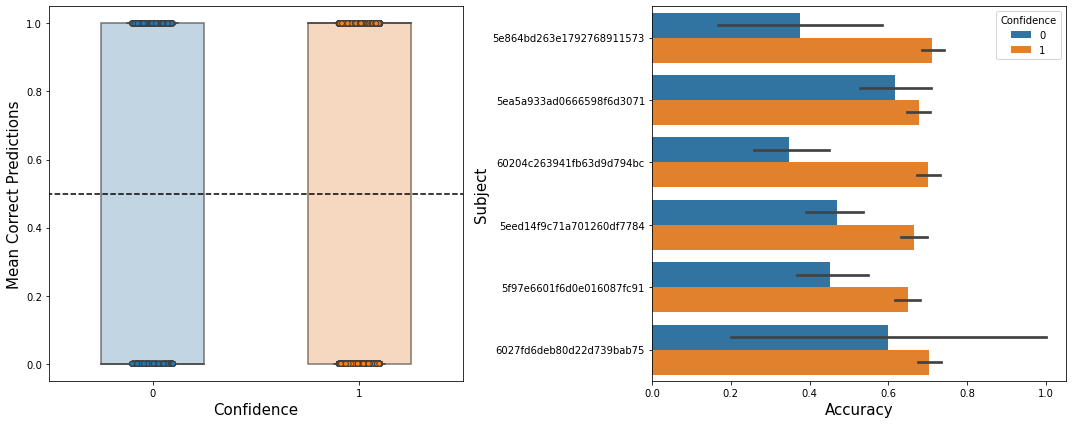

In [316]:
# Plot behavior
plt.figure(1,(15,6))
# Plot boxplots of proportion correct
plt.subplot(1,2,1)
plt.plot([-1,3],[.5,.5],'--k')
sns.boxplot(x = 'Confidence',y='Correct',data=D,dodge=True,fliersize=0,width=.5,color='white')
sns.boxplot(x = 'Confidence',y='Correct',data=D,dodge=True,fliersize=0,width=.5,boxprops=dict(alpha=.3))
sns.stripplot(x = 'Confidence',y='Correct',data=D,linewidth=1)
plt.ylim([-.05,1.05])
plt.xlim([-.5,1.5])
plt.ylabel('Mean Correct Predictions',size=15)
plt.xlabel('Confidence',size=15)

# Plot proportion correct since last source switch
plt.subplot(1,2,2)
sns.barplot(y="Subject", x="Correct", hue="Confidence", data=D)
#plt.ylim([0,1])
plt.xlabel('Accuracy',size=15)
plt.ylabel('Subject',size=15)
plt.tight_layout()

In [286]:
os.listdir(data_location)

['UrnTaskV_PARTICIPANT_SESSION_2021-04-06_18h39.32.393.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-04-06_16h53.28.590.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-04-09_15h54.33.124.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-04-09_15h57.23.880.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-04-06_18h39.29.152.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-04-06_18h50.11.304.csv',
 'UrnTaskV_PARTICIPANT_SESSION_2021-04-09_17h04.46.615.csv']

In [294]:
file1 = os.listdir(data_location)[0]
df1 = pd.read_csv(data_location + file1)

file2 = os.listdir(data_location)[4]
df2 = pd.read_csv(data_location + file2)

df1[:-1].equals(df2)

True

In [302]:
D1 = preprocess_sub_data_helper(data_location + file1, stimuli_location)
D2 = preprocess_sub_data_helper(data_location + file2, stimuli_location)

D1.equals(D2)

True

In [298]:
data_location = "./Urn-Confidence/Pilot/UrnTaskV/"
stimuli_location = "./Urn-Confidence/Pilot/StimuliV/"

file = os.listdir(data_location)[0]
print(file) 

df = pd.read_csv(data_location + file)
print(df)

UrnTaskV_PARTICIPANT_SESSION_2021-04-06_18h39.32.393.csv
                  trial_type  trial_index  time_elapsed internal_node_id  \
0                   pavlovia            0            10          0.0-0.0   
1                    preload            1            15          0.0-1.0   
2              external-html            2         31526      0.0-2.0-0.0   
3        survey-multi-choice            3         72802      0.0-2.0-1.0   
4                survey-text            4         84663      0.0-2.0-2.0   
...                      ...          ...           ...              ...   
3095   image-button-response         3095       2164745   0.0-24.0-0.499   
3096   image-button-response         3096       2165054   0.0-24.0-1.499   
3097   image-button-response         3097       2165572   0.0-24.0-2.499   
3098  html-keyboard-response         3098       2175324         0.0-25.0   
3099                pavlovia         3099       2175408         0.0-26.0   

      Script_Picker     Block_

In [198]:
df['responses'][5]
find_between(df['responses'][5],":\"","\"}")

'{"Q0":"5e864bd263e1792768911573"}'

'5e864bd263e1792768911573'

In [142]:
## Get bead and confidence response
temp = df.dropna(subset=['stimulus'])
resp_combined = temp.loc[temp['stimulus'].str.contains("NewTrial|NoChoice")].reset_index()
bead_resp = [0 if blah > 1 else 1 for blah in resp_combined['response']]
confid_resp = [1 if blah % 2 == 0 else 0 for blah in resp_combined['response']]

D = pd.DataFrame({
    'Confidence': confid_resp,
    'Response': bead_resp,
    'Combined_response': resp_combined['response']
})
D.reset_index()

,index,Confidence,Response,Combined_response
0,0,0,1,1.0
1,1,1,0,2.0
2,2,0,0,3.0
3,3,1,0,2.0
4,4,0,0,3.0
...,...,...,...,...
1015,1015,1,0,2.0
1016,1016,1,1,0.0
1017,1017,1,0,2.0
1018,1018,1,1,0.0


In [145]:
## Get Hazard

switchindex = resp_combined[resp_combined['stimulus'].str.contains("NoChoice")].index[2]
switchindex
if df['Block_Type'][0] == 'Low_HMMActual':
    hazard_list = [0.01, 0.99]
else: hazard_list = [0.99, 0.01]
    
hazard_rate = [hazard_list[0] if i < switchindex else hazard_list[1] for i in np.arange(len(resp_combined))]
#hazard_rate

510

In [153]:
## Get sequence of beads and jars
seqID = df['Script_Picker'][0]
pseq_low = pd.read_csv(stimuli_location + 'low_hazard_HMM/low_hazard_HMM'+str(seqID)+'.csv')
pseq_high = pd.read_csv(stimuli_location + 'high_hazard_HMM/high_hazard_HMM'+str(seqID)+'.csv')

training_length = 10
if df['Block_Type'][0] == 'Low_HMMActual':
    pseq = pd.concat([pseq_low[:training_length],pseq_low, pseq_high[:training_length], pseq_high])
else:
    pseq = pd.concat([pseq_high[:training_length],pseq_high, pseq_low[:training_length], pseq_low])
    
pseq = pseq.reset_index()
pseq

,index,Urn,Bead
0,0,1.0,2.0
1,1,1.0,1.0
2,2,1.0,2.0
3,3,1.0,1.0
4,4,1.0,1.0
...,...,...,...
1015,495,2.0,2.0
1016,496,1.0,1.0
1017,497,2.0,1.0
1018,498,1.0,2.0


In [221]:
D = pd.DataFrame({
    'Confidence': confid_resp,
    'Response': bead_resp,
    'Combined_response': resp_combined['response'],
    'Hazard': hazard_rate,
    'Jar': [int(2-i) for i in pseq['Urn']],
    'Bead': [int(2-i) for i in pseq['Bead']]
})
D

,Confidence,Response,Combined_response,Hazard,Jar,Bead
0,0,1,1.0,0.01,1,0
1,1,0,2.0,0.01,1,1
2,0,0,3.0,0.01,1,0
3,1,0,2.0,0.01,1,1
4,0,0,3.0,0.01,1,1
...,...,...,...,...,...,...
1015,1,0,2.0,0.99,0,0
1016,1,1,0.0,0.99,1,1
1017,1,0,2.0,0.99,0,1
1018,1,1,0.0,0.99,1,0


In [190]:
## Check stuff
check_set = ['Images/BlackBeadChoiceWrong.png',
            'Images/WhiteBeadChoiceWrong.png',
            'Images/BlackBeadChoiceCorrect.png',
            'Images/WhiteBeadChoiceCorrect.png']
check_set_string = "|".join(check_set)

check_table = pd.DataFrame()
check_table['stim'] = temp['stimulus'].loc[temp['stimulus'].str.contains(check_set_string)]
check_table['check_resp'] = [0 if "White" in i else 1 for i in check_table['stim']]
check_table['check_correct'] = [0 if "Wrong" in i else 1 for i in check_table['stim']]
check_table = check_table.reset_index()

D['check_resp'] = check_table['check_resp']
D['check_correct'] = check_table['check_correct']

In [222]:
D['Correct'] = [1 if D['Response'][i] == D['Bead'][i] else 0 for i in np.arange(len(D))]
D

#list(D['Correct']) == list(D['check_correct'])
#list(D['Response']) == list(D['check_resp'])

,Confidence,Response,Combined_response,Hazard,Jar,Bead,Correct
0,0,1,1.0,0.01,1,0,0
1,1,0,2.0,0.01,1,1,0
2,0,0,3.0,0.01,1,0,1
3,1,0,2.0,0.01,1,1,0
4,0,0,3.0,0.01,1,1,0
...,...,...,...,...,...,...,...
1015,1,0,2.0,0.99,0,0,1
1016,1,1,0.0,0.99,1,1,1
1017,1,0,2.0,0.99,0,1,0
1018,1,1,0.0,0.99,1,0,0


In [39]:
# Make into object
def get_sub_dat(fname,snum):
   # Load raw response data
    pdf = pd.read_csv('./Urn-Confidence/Pilot/UrnTaskV/'+fname)

    # Load session trial info
    seqID = pdf['Script_Picker'][0]
    pseq1 = pd.read_csv('./Urn-Confidence/Pilot/StimuliV/low_hazard_HMM/low_hazard_HMM'+str(seqID)+'.csv')
    pseq2 = pd.read_csv('./Urn-Confidence/Pilot/StimuliV/high_hazard_HMM/high_hazard_HMM'+str(seqID)+'.csv')
    seqDict = {'HMM_low':pseq1, 'HMM_high':pseq2}

    # Add response code to match data sequence file
    stim_im = ["Images/NewTrialBC.png","Images/NewTrialWC.png","Images/NoChoice.png", 
               "Images/NoChoiceMM.png", "Images/NewTrialWCMM.png", "Images/NewTrialBCMM.png"]
    pdf['resp']=np.nan
    pdf['resp'].loc[(pdf['key_press'] == 37) & (pdf['stimulus'].isin(stim_im))] = 1
    pdf['resp'].loc[(pdf['key_press'] == 39) & (pdf['stimulus'].isin(stim_im))] = 2

    # Add bead info
    pdf['bead'] = np.nan
    offset = np.array(pdf['stimulus'])
    beads = np.zeros((len(offset)))-1
    beads[np.isin(offset,["Images/BlackBeadChoiceCorrect.png","Images/WhiteBeadChoiceWrong.png",
                         "Images/BlackBeadChoiceCorrectMM.png","Images/WhiteBeadChoiceWrongMM.png"])] = 1
    beads[np.isin(offset,["Images/WhiteBeadChoiceCorrect.png","Images/BlackBeadChoiceWrong.png",
                         "Images/WhiteBeadChoiceCorrectMM.png","Images/BlackBeadChoiceWrongMM.png"])] = 2
    pdf['bead'].iloc[:-2] = beads[2:]

    # Add session number and condition
    # Get indicies of start and finish of each block
    pdf['session_num'] = np.nan
    pdf['condition'] = np.nan
    sess_order = ['HMM_low','MM_low','HMM_high','MM_high']
    bidx = []
    # Get all indicies where key_press is equal to 32 - helps demarcate block bounds
    p32 = pdf[pdf['key_press'] == 32]
    for i in np.arange(4):
        if i == 0:
            sidx = (p32.index[p32.index < 100].max(), p32.index[(p32.index > 100)].min())
        else:
            prevIdx = bidx[i-1][1]
            start = p32.index[p32.index > prevIdx].min()
            end = p32.index[p32.index > start].min()
            sidx = (start,end)
        bidx.append(sidx)

        # Add session info
        pdf['session_num'].loc[pdf.index.isin(np.arange(sidx[0]+1,sidx[1]))] = i+1
        pdf['condition'].loc[pdf.index.isin(np.arange(sidx[0]+1,sidx[1]))] = sess_order[i]

    # Get jar info
    jar = np.concatenate((np.array(pseq1['Urn']),
                         np.array(pseq2['Urn']),
                         np.array(pseq3['Urn']),
                         np.array(pseq4['Urn'])))
    
    # Get clean data and check that bead sequences match per session
    # Also add trial since jar changepoint
    pdf_clean = pdf[pdf['resp'].notna()].copy()
    pdf_clean['TSCP'] = np.nan
    pdf_clean['TSCP2'] = np.nan
    for i,sess in enumerate(sess_order):
        seqBeads = np.array(seqDict[sess]['Bead'])
        rawBeads = np.array(pdf_clean['bead'].loc[pdf_clean['condition'] == sess])
        if sum(seqBeads!=rawBeads)>0:
            print('Data not aligned for subject %str'%str(snum))

        # Get trial since changepoint
        tscp = 0
        currJar = 0
        tscp_vc = np.zeros(len(seqBeads))
        for i,j in enumerate(seqDict[sess]['Urn']):
            if i == 0:
                currJar = j
            else:
                if currJar !=j:
                    tscp = 0
                    currJar = j
                else:
                    tscp += 1
            tscp_vc[i] = tscp
        pdf_clean['TSCP'].loc[pdf_clean['condition'] == sess] = tscp_vc
        pdf_clean['TSCP2'].loc[pdf_clean['TSCP'] == 0] = '0'
        pdf_clean['TSCP2'].loc[pdf_clean['TSCP'] == 1] = '1'
        pdf_clean['TSCP2'].loc[pdf_clean['TSCP'] == 2] = '2'
        pdf_clean['TSCP2'].loc[pdf_clean['TSCP'].isin([3,4])] = '3-4'
        pdf_clean['TSCP2'].loc[pdf_clean['TSCP'].isin([5,6,7])] = '5-7'
        pdf_clean['TSCP2'].loc[pdf_clean['TSCP']>7] = '8+'

    # Create new data frame with columns of interest
    df = pd.DataFrame({
        "Subject": np.array([snum]*len(jar)),
        "Sequence": np.array([seqID]*len(jar)),
        "Session": pdf_clean['condition'],
        "SessTrial": np.concatenate((np.arange(1,201),np.arange(1,201),np.arange(1,201),np.arange(1,201))),
        "TSCP": pdf_clean['TSCP'],
        "TSCP2": pdf_clean['TSCP2'],
        "Jar":jar,
        "Bead": pdf_clean['bead'],
        "Resp": pdf_clean['resp'],
        "Correct_Bead": np.array(np.array(pdf_clean['resp']) == np.array(pdf_clean['bead'])).astype(int), 
        "Correct_Jar": np.array(np.array(pdf_clean['resp']) == jar).astype(int),
        "RT": pdf_clean['rt']
    })

    return(df) 

In [45]:
file = os.listdir(data_location)[0]
get_sub_dat(file,'asdf')

/Users/vwang/anaconda3/envs/ndd/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


ValueError: arange: cannot compute length

In [ ]:
 & (('NoChoice' in df['stimulus']) | ('NewTrial' in df['stimulus']))

In [ ]:
if df['Block_Type'] == 'Low_HMMActual':
    pseq1 = pd.read_csv(stimuli_location + 'low_hazard_HMM/low_hazard_HMM'+str(seqID)+'.csv')
    pseq2 = pd.read_csv(stimuli_location + 'high_hazard_HMM/high_hazard_HMM'+str(seqID)+'.csv')
    seqDict = {'HMM_low':pseq1,'HMM_high':pseq2}
else:
    pseq1 = pd.read_csv(stimuli_location + 'high_hazard_HMM/high_hazard_HMM'+str(seqID)+'.csv')
    pseq2 = pd.read_csv(stimuli_location + 'low_hazard_HMM/low_hazard_HMM'+str(seqID)+'.csv')
    seqDict = {'HMM_low':pseq2,'HMM_high':pseq1}

In [ ]:
#### Code for low and high together

def preprocess_sub_data(data_location, stimuli_location, training_length = 10):
    full_data = pd.DataFrame()
    subject_list = []
    for file in os.listdir(data_location):
        if file[0] == ".": continue
        sub_data = preprocess_sub_data_helper(data_location + file, stimuli_location, training_length)
        if sub_data['Subject'][0] not in subject_list:
            subject_list.append(sub_data['Subject'][0])
            full_data = full_data.append(sub_data,ignore_index=True)
        #print(subject_list)
    return full_data
        
def preprocess_sub_data_helper(file_location, stimuli_location, training_length = 10):
    ## Read in subject data
    df = pd.read_csv(file_location)
    
    ## Read in subject stimulus data
    seqID = df['Script_Picker'][0]
    pseq_low = pd.read_csv(stimuli_location + 'low_hazard_HMM/low_hazard_HMM'+str(seqID)+'.csv')
    pseq_high = pd.read_csv(stimuli_location + 'high_hazard_HMM/high_hazard_HMM'+str(seqID)+'.csv')
    
    ## Subject identifier
    sub = find_between(df['responses'][5],":\"","\"}")
    
    ## Get bead and confidence responses
    temp = df.dropna(subset=['stimulus'])
    resp_combined = temp.loc[temp['stimulus'].str.contains("NewTrial|NoChoice")].reset_index()
    bead_resp = [0 if blah > 1 else 1 for blah in resp_combined['response']]
    confid_resp = [1 if blah % 2 == 0 else 0 for blah in resp_combined['response']]
    
    ## Get hazard rates
    switchindex = resp_combined[resp_combined['stimulus'].str.contains("NoChoice")].index[2]
    switchindex
    if df['Block_Type'][0] == 'Low_HMMActual':
        hazard_list = [0.01, 0.99]
    else: hazard_list = [0.99, 0.01]
    hazard_rate = [hazard_list[0] if i < switchindex else hazard_list[1] for i in np.arange(len(resp_combined))]
    
    ## Get true sequence of beads and jars
    if df['Block_Type'][0] == 'Low_HMMActual':
        pseq = pd.concat([pseq_low[:training_length],pseq_low, pseq_high[:training_length], pseq_high])
    else:
        pseq = pd.concat([pseq_high[:training_length],pseq_high, pseq_low[:training_length], pseq_low])
    pseq = pseq.reset_index()
    
    ## Gather outputs
    D = pd.DataFrame({
        'Subject': sub,
        'Trial': [i for i in np.arange(len(pseq))],
        'H': hazard_rate,
        'Jar': [int(2-i) for i in pseq['Urn']],
        'Bead': [int(2-i) for i in pseq['Bead']],
        'Response': bead_resp,
        'Confidence': confid_resp#,
        #'Combined_response': resp_combined['response']
    })
    D['Correct'] = [1 if D['Response'][i] == D['Bead'][i] else 0 for i in np.arange(len(D))]

    ## Check stuff
    check_set = ['Images/BlackBeadChoiceWrong.png',
                'Images/WhiteBeadChoiceWrong.png',
                'Images/BlackBeadChoiceCorrect.png',
                'Images/WhiteBeadChoiceCorrect.png']
    check_set_string = "|".join(check_set)

    check_table = pd.DataFrame()
    check_table['stim'] = temp['stimulus'].loc[temp['stimulus'].str.contains(check_set_string)]
    check_table['check_resp'] = [0 if "White" in i else 1 for i in check_table['stim']]
    check_table['check_correct'] = [0 if "Wrong" in i else 1 for i in check_table['stim']]
    check_table = check_table.reset_index()
    
    check1 = list(D['Correct']) != list(check_table['check_correct'])
    check2 = list(D['Response']) != list(check_table['check_resp'])
    
    if check1 | check2:
        print("PROBLEM")
    return D

In [ ]:
D[(D['Subject'] == "6027fd6deb80d22d739bab75") & (D['H'] == 0.01)]

plt.figure(1,(8,6))
plt.plot("Trial", "Confidence",'.',data = D[(D['Subject'] == "6027fd6deb80d22d739bab75") & (D['H'] == 0.01)])
plt.plot("Trial", "Confidence",'.',data = D[(D['Subject'] == "6027fd6deb80d22d739bab75") & (D['H'] == 0.99)])

In [310]:
x = np.array([1,2,1,1,2,2,1,1,1,2,2,1,2])
x = x-1
x
z = np.arange(13)
xw,zw = get_windowed_x(x,z,2)

xw1,zw1 = get_windowed_x_v(get_previous_n_beads(2,x),z,2)

[np.binary_repr(int(h),2) for h in xw]
xw
zw

[int(h[1:][::-1],2) for h in get_previous_n_beads(2,x)][2:]

'''
x = np.array([1,1,1,1,1,1,1,1,1,2,2,1,2])
x = x-1
x
z = np.zeros(13)
xw,zw = get_windowed_x(x,z,2)

[np.binary_repr(int(h),2) for h in xw]
xw
zw'''

array([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1])

['10', '01', '00', '10', '11', '01', '00', '00', '10', '11', '01']

array([2, 1, 0, 2, 3, 1, 0, 0, 2, 3, 1])

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

[2, 1, 0, 2, 3, 1, 0, 0, 2, 3, 1]

'\nx = np.array([1,1,1,1,1,1,1,1,1,2,2,1,2])\nx = x-1\nx\nz = np.zeros(13)\nxw,zw = get_windowed_x(x,z,2)\n\n[np.binary_repr(int(h),2) for h in xw]\nxw\nzw'

In [956]:
D_ideal_full['Abs_Prior'] = abs(0.5 - D_ideal_full['Prior'])
#D_ideal_full
trials_ideal_high = D_ideal_full.sort_values('Abs_Prior',ascending = False)['Trial'].head(num_high).values
#trials_ideal_high
#np.array(trials_ideal_high['Trial'])
len(trials_ideal_high)

1002 in trials_ideal_high
b = np.array([int(t in trials_ideal_high) for t in D_ideal['Trial']])
b.sum()

D_ideal['Trial']
D_ideal['Trial'].max()
D_ideal.loc[D_ideal['Trial'].isin(trials_ideal_high)]

#len(set.intersection(set(trials_ideal_high), set(D_ideal['Trial'])))
#set.difference(set(D_ideal['Trial']), set(np.arange(len(D_ideal))))

897

True

897

0        10
1        11
2        12
3        13
4        14
       ... 
995    1005
996    1006
997    1007
998    1008
999    1009
Name: Trial, Length: 1000, dtype: int64

1009

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History
2,5de00d05988d7c0877eaa15a_Random_Ideal,12,0,0,0,1,1,01110111100
3,5de00d05988d7c0877eaa15a_Random_Ideal,13,0,0,0,1,1,01101111000
4,5de00d05988d7c0877eaa15a_Random_Ideal,14,0,0,0,1,1,01011110000
5,5de00d05988d7c0877eaa15a_Random_Ideal,15,0,0,0,1,1,00111100000
6,5de00d05988d7c0877eaa15a_Random_Ideal,16,0,0,0,1,1,01111000000
...,...,...,...,...,...,...,...,...
995,5de00d05988d7c0877eaa15a_Random_Ideal,1005,0,0,0,1,1,00000100000
996,5de00d05988d7c0877eaa15a_Random_Ideal,1006,0,0,0,1,1,00001000000
997,5de00d05988d7c0877eaa15a_Random_Ideal,1007,0,0,0,1,1,00010000000
998,5de00d05988d7c0877eaa15a_Random_Ideal,1008,0,0,0,1,1,00100000000
